## Problem Statement

As a fan of Jeopardy, if one was to prepare to go on the show or just wanted to practice being better at it, how could one devise a study plan? 

If you had all the questions and answers for every Jeopardy show, that would be useful.  However, 35 years of shows is a lot to study. The goal of this project is to analyze all the data from every Jeopardy show and build a model that constructs the most frequently used keywords for the most frequently occuring answers.  Then look at how much of an advantage this would give you, if you concentrated on studying just this subset.

The measure would be the actual dollar amount increase you could potentially gain on one particular show. Actually winning the show depends on what the other contestants score, so that would not be realistic to take into account.  The idea here is that if you could increase your own performance, then it follows that you would have a better chance of winning.

The final output will be an online dashboard in which one can choose topics and associated keywords as word clouds and learn what answers are most commonly associated with those keywords.  

A recent contestant from October of 2020 who is a data scientist had a similar idea and analyzed years jeopardy data and constructed flash cards of word clouds keywords.  My approach will be similar but the end result will be online for anyone to use. Here is a link to his blog: https://colindavy.medium.com/how-i-won-jeopardy-with-data-science-c2e9b52a1958

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Category Analysis](#Category-Analysis)
- [Topic Modeling](#Topic-Modeling)
- [Keyword Extraction](#Keyword-Extraction)
- [Model Evaluation](#Model-Evaluation)
- [Statistical Tests](#Statistical-Tests)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

Watching recent shows I noticed knowing who a particular Secretary of State is comes up often as a question.  So, I played a game that if I did not know the answer and had to guess I would pick Madeline Albright.  The next show I watched this question did come up and Madeline Albright was indeed the correct answer. I could follow the same logic with Russian composers, American Authors, etc.… Then if I prepared myself well in all of these types of questions, I could potentially increase the amount of money I could earn in one game.

In Jeopardy, games often come down to one question being the difference, often the Final Jeopardy question but also getting Daily Doubles and high score questions can be significant to your final score.

I found a dataset on Kaggle of 350,000 actual Jeopardy questions which is the basis for this study: https://www.kaggle.com/prondeau/350000-jeopardy-questions/code

## Data Import and Cleaning

### import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from collections import  Counter
import en_core_web_lg
nlp = spacy.load("en_core_web_lg")
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pd.set_option('display.max_colwidth', None);
import gensim
import yake
import re
from wordcloud import WordCloud

C:\Users\kirkl\anaconda3\envs\dsi_py38\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Import jeopardy main show data

In [3]:
jp = pd.read_csv('../data/master_season1-35.tsv', sep = '\t', engine = 'python')

### read sample

In [4]:
jp.head()

round  value daily_double        category comments  \
0      1    100           no  LAKES & RIVERS        -   
1      1    200           no  LAKES & RIVERS        -   
2      1    400           no  LAKES & RIVERS        -   
3      1    500           no  LAKES & RIVERS        -   
4      1    100           no      INVENTIONS        -   

                                                      answer         question  \
0                    River mentioned most often in the Bible       the Jordan   
1                                     Scottish word for lake             loch   
2  American river only 33 miles shorter than the Mississippi     the Missouri   
3    World's largest lake, nearly 5 times as big as Superior  the Caspian Sea   
4                               Marconi's wonderful wireless        the radio   

     air_date notes  
0  1984-09-10     -  
1  1984-09-10     -  
2  1984-09-10     -  
3  1984-09-10     -  
4  1984-09-10     -

## The steps below will lowercase columns, convert data types, and create a year column for the year of the show.

### rename columns

In [5]:
jp.rename(columns={'answer': 'question', 'question': 'ans'}, inplace = True)
jp.rename(columns={'ans': 'answer'}, inplace = True)

### lowercase text fields

In [6]:
##jp['question'] = jp['question'].str.lower()
jp['answer'] = jp['answer'].str.lower()
jp['category'] = jp['category'].str.lower()

### check data types and empty values

In [7]:
jp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349641 entries, 0 to 349640
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   round         349641 non-null  int64 
 1   value         349641 non-null  int64 
 2   daily_double  349641 non-null  object
 3   category      349641 non-null  object
 4   comments      349641 non-null  object
 5   question      349641 non-null  object
 6   answer        349641 non-null  object
 7   air_date      349641 non-null  object
 8   notes         349641 non-null  object
dtypes: int64(2), object(7)
memory usage: 24.0+ MB


### convert air date to datetime

In [8]:
jp['air_date'] = pd.to_datetime(jp['air_date'])

### create a year column for the year of the air date

In [9]:
jp['year'] = pd.DatetimeIndex(jp['air_date']).year

### save cleaned data to csv file

In [ ]:
##jp.to_csv('../data/jp.csv', index = False)

In [10]:
jp.to_csv('../data/jp(noquestionlowering).csv', index = False)

In [15]:
jp = pd.read_csv('../data/jp(noquestionlowering).csv')

# Exploratory Data Analysis

## Analyze Unique Answers

In [16]:
answers_unq = jp.groupby('answer').count()

In [17]:
answers_unq.shape

(107421, 9)

In [18]:
jp.shape

(349641, 10)

### We created a unique answers dataframe and found we have 107421 out of 349641 total answers, about 30 percent of the data.

### We are not interested in any answers appearing only once; the scope of the project is to analyze only the most frequently occuring answers.  We create a top answers data frame to filter out answers only appearing once. We also include the last year that the answer occured in.

In [19]:
top_answers = answers_unq.loc[answers_unq['year']> 1].index.values

In [20]:
top_answers.size

43554

In [21]:
c = Counter(jp['answer'])

In [22]:
jp_top_answers = pd.DataFrame(columns = ['answer','answer_count','year'])

In [23]:
jp_top_answers['answer_count'] = [el[1] for el in c.most_common() if el[1] > 1] 

In [24]:
jp_top_answers['answer'] = [el[0] for el in c.most_common() if el[1] > 1]

In [25]:
for i in range(0,43554):
    jp_top_answers['year'][i] = jp.loc[jp['answer'] == jp_top_answers['answer'][i]]['year'].max();

In [26]:
jp_top_answers.to_csv('top_answers.csv')

In [27]:
jp_top_answers.shape

(43554, 3)

### We see there are 43554 total answers that appear more than once.  Now we will create a new jp dataframe that contains only these answers.

In [28]:
jp_top_df = jp.loc[jp['answer'].isin(top_answers)]

In [29]:
jp_top_df.shape

(285774, 10)

### We see that the total number of questions that contain answers appearing more than once is 285774, about 82% of the total data

## Data Visualizations of Answers by Count and Year

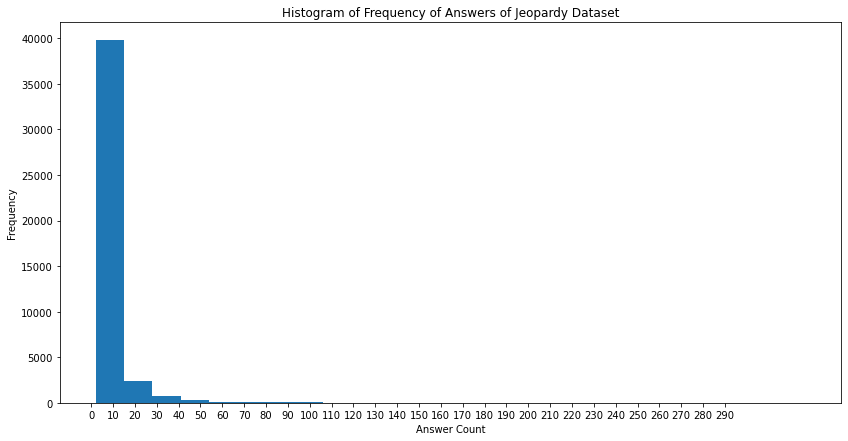

In [31]:
plt.figure(figsize=(14, 7))
plt.title('Histogram of Frequency of Answers of Jeopardy Dataset')
plt.xlabel('Answer Count')
jp_top_answers['answer_count'].plot(kind ='hist',bins = 25, xticks = range(0,300,10));

### We see that the distribution of answer frequency is right skewed. There seems to be a huge dropoff around 12.

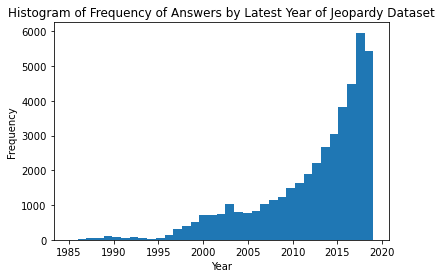

In [37]:
plt.title('Histogram of Frequency of Answers by Latest Year of Jeopardy Dataset')
plt.xlabel('Year')
jp_top_answers['year'].plot(kind='hist',bins = 35);

### We see that number of repeated answers by the latest year increase significantly after 1997 up to 2018.

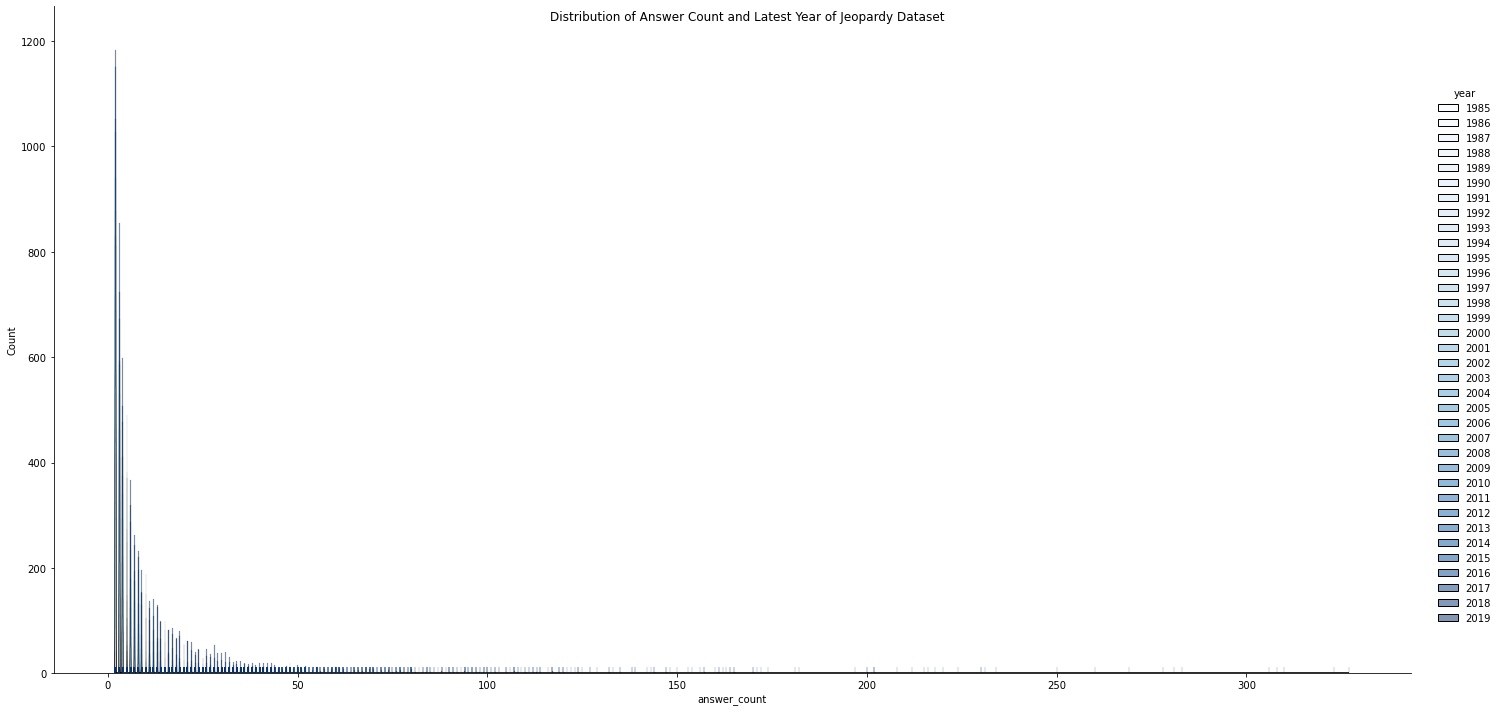

In [45]:
dis = sns.displot(data = jp_top_answers,x='answer_count', hue='year', palette = 'Blues', aspect = 2, height = 10, rug = True, rug_kws={"color": "r", "alpha": 0.1, "linewidth": 2, "height":0.01})
dis.fig.suptitle('Distribution of Answer Count and Latest Year of Jeopardy Dataset');


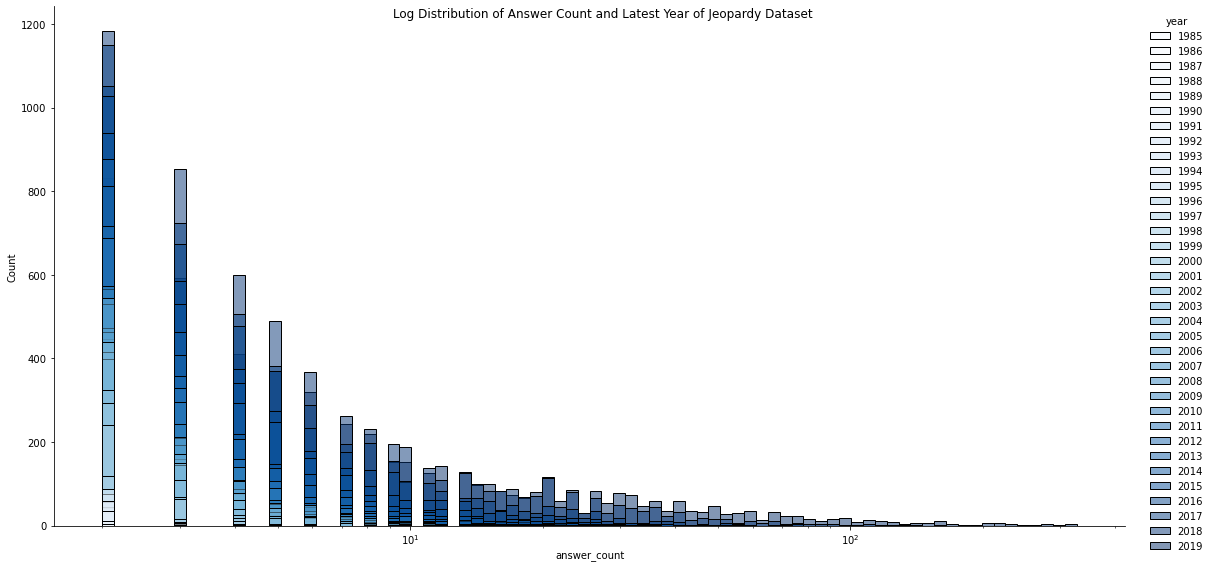

In [46]:
dislog = sns.displot(data = jp_top_answers,x='answer_count', hue='year', palette = 'Blues', aspect = 2, height = 8 , log_scale = True)
dislog.fig.suptitle('Log Distribution of Answer Count and Latest Year of Jeopardy Dataset');

### The above 2 graphs show the distribution plots of the answer frequency with a hue of the years added in.  The second one is a log scale which is added becuase it is much easier to see the trends.  Again we see the right skewed nature of the distribution and that the frequencies increase in the later years.   

### From the above analysis, we will now only consider answers who appear more than the 11.  Below that we do not think it worthwhile to analyze becuase the total of answers 11 or below represent a large proportion of the answers and the probability of those actually showing up in a particular show will be much lower.  

In [33]:
top_answers = answers_unq.loc[answers_unq['round']>11].index.values

In [34]:
top_answers.shape

(5168,)

### We see that we now have reduced our unique answers to analyze to 5168.

#### create a new top answer dataframe

In [35]:
jp_top = jp_top_df.loc[jp_top_df['answer'].isin(top_answers)]

In [37]:
jp_top.to_csv('jp_top.csv', index = False)

#### the new dataframe contains 1407010 questions

In [38]:
jp_top.shape

(140710, 10)

In summary, the 5168 answers account for 140710 questions, which is about 40 percent of the total data. By only keeping 5168 answers, which is about 12% of the unique answers, we still cover 40% of the total questions.¶

## Category Analysis

#### First we look at some of the top most occuring answers

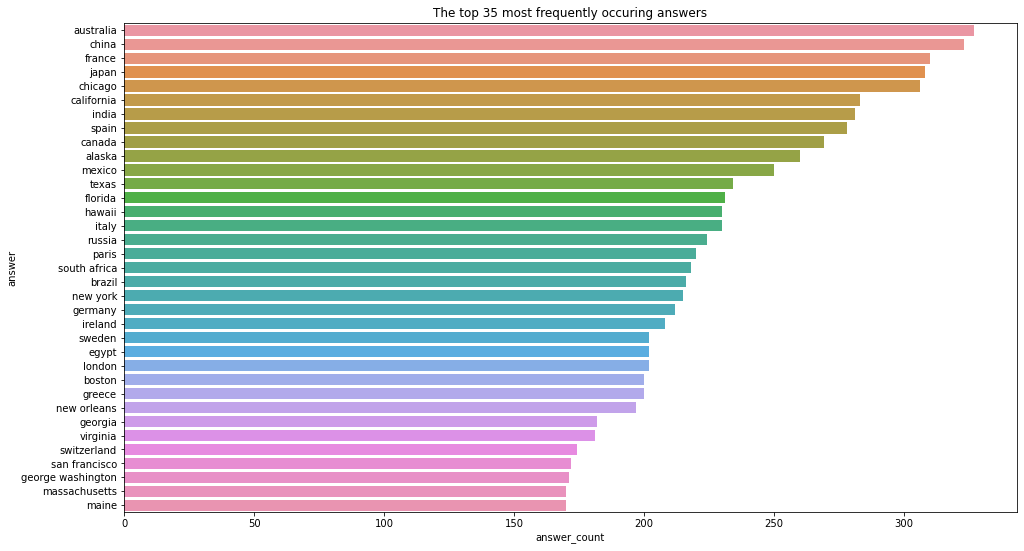

In [39]:
plt.figure(figsize = (16,9))
plt.title('The top 35 most frequently occuring answers')
sns.barplot(data = jp_top_answers.head(35), x = 'answer_count', y = 'answer');

In [40]:

jp_top_df.loc[jp['answer'] == 'george washington']

round  value daily_double                category comments  \
1351        1    300           no     presidential firsts        -   
2057        1    300           no     presidential trivia        -   
2882        1    200           no     american revolution        -   
3211        3      0           no       the supreme court        -   
3585        1    100           no     presidential trivia        -   
...       ...    ...          ...                     ...      ...   
300174      2    400           no           u.s. marshals        -   
326481      2    400           no         dental problems        -   
344699      2    800           no  18th century nicknames        -   
345418      2   1200           no        american history        -   
348234      1    200           no         u.s. presidents        -   

                                                                                                                             question  \
1351                                                                                               1st president to refuse a 3rd term   
2057                                             For the presidential portraits, Gilbert Stuart stuffed his sunken cheeks with cotton   
2882                                                          General Howe faced him in Brandywine, Germantown, & Long Island battles   
3211                                                              This president appointed more Supreme Court justices than any other   
3585                                                            President who wore size 13 shoes & probably never told a lie about it   
...                                                                                                                               ...   
300174      The oldest federal law-enforcement agency, the U.S. Marshals were established when this man signed the 1789 Judiciary Act   
326481                        At age 57 in 1789 he had only one tooth remaining & wore dentures of hippo ivory made by John Greenwood   
344699         This president was "The American Cincinnatus", after a Roman who answered the call to leadership but preferred farming   
345418  In 1976, more than 175 years after his death, this man was promoted by Congress to general of the armies of the United States   
348234                                                                He's the only U.S. president who never lived in the White House   

                   answer    air_date  \
1351    george washington  1984-12-10   
2057    george washington  1985-09-09   
2882    george washington  1985-11-14   
3211    george washington  1985-11-21   
3585    george washington  1985-12-25   
...                   ...         ...   
300174  george washington  2015-07-02   
326481  george washington  2017-10-04   
344699  george washington  2019-03-21   
345418  george washington  2019-04-09   
348234  george washington  2019-06-21   

                                                    notes  year  
1351                                                    -  1984  
2057                                                    -  1985  
2882    1985 Tournament of Champions quarterfinal game 4.  1985  
3211           1985 Tournament of Champions final game 1.  1985  
3585                                                    -  1985  
...                                                   ...   ...  
300174                                                  -  2015  
326481                                                  -  2017  
344699                                                  -  2019  
345418                                                  -  2019  
348234          2019 Teen Tournament quarterfinal game 5.  2019  

[171 rows x 10 columns]

### Note: My first idea in this project was to break down common answers according to common categories.  There are some difficulties to doing this.  As we see George Washington is a top answer and appears 171 times but on inspection appears in a wide variety of categories; some seemingly totally unrelated such as dental problems, the supreme court, and u.s. marshalls.

In [44]:
### count unique categories
categories_unq = jp_top.groupby('category').nunique()
categories = (categories_unq.index.values)
len(categories) 

33253

### We see that even in our top answers of 5168 there are a total of 33256 unique categories

In [45]:
categories[500:1100]

array(['1999 u.s. stamps', '19th c. america', '19th c. americans',
       '19th c. newspaper publishers', '19th century',
       '19th century africa', '19th century america',
       '19th century american authors', '19th century american history',
       '19th century american lit', '19th century american literature',
       '19th century americans', '19th century art',
       '19th century art & history', '19th century authors',
       '19th century bigwigs', '19th century books',
       '19th century books & authors', '19th century brit lit',
       '19th century british authors', '19th century british literature',
       '19th century brits', '19th century business',
       '19th century business leaders', '19th century businessmen',
       '19th century classical musicians', '19th century congressmen',
       '19th century construction', '19th century democrats',
       '19th century europe', '19th century europeans',
       '19th century female authors', '19th century fiction',
 

### above is an inspection of some of the many categories 

### Most Common Words in sample of categories

In [49]:
### create a set of words from a Count Vectorizer of a random sample of 10000 categories
jp_sample = jp_top['category'].sample(n=10000, random_state=42)
cvec = CountVectorizer(min_df = 2, stop_words = 'english')
cvec.fit(jp_sample)
jb = cvec.transform(jp_sample)
jp_cat_words = pd.DataFrame(jb.todense(), columns = cvec.get_feature_names()) ;

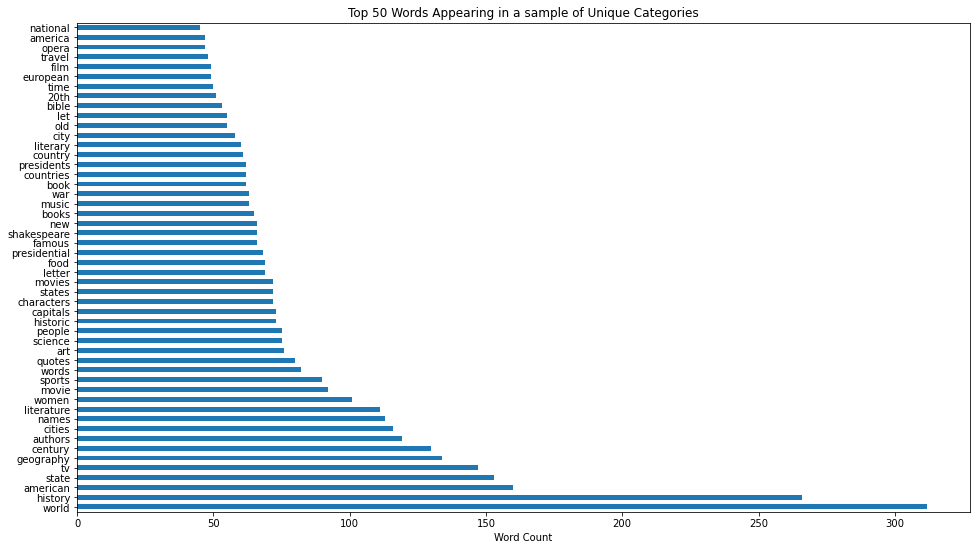

In [52]:
### plot the most frequently occuring words in a sample of categories
plt.figure(figsize = (16,9))
plt.title('Top 50 Words Appearing in a sample of Unique Categories')
plt.xlabel('Word Count')
jp_cat_words.sum().sort_values(ascending = False).head(50).plot(kind = 'barh');

### We are looking at just a subsample of the top words appearing in unique categories.  This is just to get a sense if it is possible to break down specific categories into broader categories. Certainly many of these such as tv, movies, shakespeare, opera, e.g... can be considered categories unto themselves.

### To further analyze, we are going to pivot and try a topic modeling approach

## Topic Modeling

### Note: Most of the code and analysis following was taken and modified from the following blog: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

### Define helper functions to prepare text for analysis

In [53]:
def tokenize(text):
    '''
    returns a list of tokens from a string of text
    '''
    return nltk.word_tokenize(text)

In [54]:
### functions to lemmatize words
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

from nltk.stem.snowball import EnglishStemmer
def get_stem(word):
    return EnglishStemmer().stem(word)

#### define stop words

In [55]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [56]:
def prepare_text_for_lda(text):
    '''
    parses a line of text and returns a list of lemmatized words which are not stopwords and whose length is greater than 3
    '''
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

#### example of above function

In [57]:
prepare_text_for_lda('20th century operas')

['20th', 'century', 'opera']

### Topic Modeling By Answer and category

In [58]:
def pyldavis_visualize(text_data,NUM_TOPICS,NUM_WORDS):
    '''
    This functions prepares a gensim model for topic analysis and visualization
    parameters:
       text_data - a list of sentences to pass in
       NUM_TOPICS - number of topics to return
       NUM_WORDS  - number of topic words in each topic to return as text
    returns:
       topics - a list of topics with keywords
       vis - a PyLDavis visualization
       ldamodel - a genism model
    
    '''
    from gensim import corpora
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    #### Build lda model 
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

    ###E build topics list
    topics = ldamodel.print_topics(num_words=NUM_WORDS)
    #### Build visualization 
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(ldamodel, corpus, dictionary)
    return (topics,vis,ldamodel)

### prepare sentences from the category and questions fields of the top dataframes and return a list of the processed sentences and creates a new keywords dataframe

In [59]:
keywords_df = jp_top
keywords_df['text_data'] = ''
text_data = []
i = 0
for line in keywords_df['category'] + ' ' + keywords_df['question']:
    tokens = prepare_text_for_lda(line)
    text_data.append(tokens)

#### add processed text data to keywords dataframe

In [60]:
i = 0
for s in text_data:
    keywords_df['text_data'].iloc[i] =  ' '.join(s)
    i += 1;

### a sample of keywords taken from the questions and categories

In [61]:
keywords_df[['category','question','answer','text_data']].tail()

category  \
349602     turning to sports   
349614               chillax   
349620  on this day: july 26   
349627              1960s tv   
349628              1960s tv   

                                                                                                                      question  \
349602                             This "Brown Bomber" successfully defended his heavyweight crown 25 times, with 22 knockouts   
349614                                                                  Enjoy a glass of the tawny type of this fortified wine   
349620                           Liberia dates its founding from the signing of its constitution in this city on July 26, 1847   
349627  In 1968 episode No. 1 of this news show that's still on had behind-the-scenes looks at Richard Nixon & Hubert Humphrey   
349628    I'm so glad we had this woman's variety show that had Jim Nabors as its first guest & as the first guest each season   

               answer  \
349602      joe louis   
349614           port   
349620       monrovia   
349627     60 minutes   
349628  carol burnett   

                                                                                      text_data  
349602     turning sport This Brown Bomber successfully defend heavyweight crown times knockout  
349614                                              chillax Enjoy glass tawny type fortify wine  
349620                           july Liberia date founding signing constitution city July 1847  
349627  1960s 1968 episode news show still behind-the-scenes look Richard Nixon Hubert Humphrey  
349628                      1960s glad woman variety show Nabors first guest first guest season

### create a word count column of the keywords text

In [62]:
keywords_df['word_count'] = keywords_df['text_data'].apply(lambda x: len(x.split()));

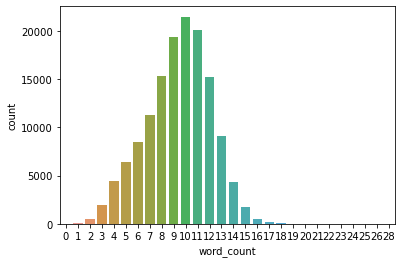

In [63]:
sns.countplot(keywords_df['word_count']);

### we see that the number of words of the processed text appears to be normally distributed around the median of 10

In [64]:
keywords_df['word_count'].describe()

count    140710.000000
mean          9.390612
std           2.710512
min           0.000000
25%           8.000000
50%          10.000000
75%          11.000000
max          28.000000
Name: word_count, dtype: float64

## TOPIC MODEL VISUALIZATIONS

### Note that I found some issues with the pyldavis rendering on github so I am attaching images of the plotting results for now.

### run and save 5 topics model

In [65]:
model_5_topics = pyldavis_visualize(text_data,5,5);

In [67]:
#### top 5 words of each topic returned
model_5_topics[0]

[(0,
  '0.015*"first" + 0.013*"president" + 0.009*"make" + 0.006*"U.S." + 0.005*"band"'),
 (1,
  '0.029*"country" + 0.023*"city" + 0.018*"capital" + 0.017*"world" + 0.016*"name"'),
 (2,
  '0.014*"play" + 0.013*"movie" + 0.012*"show" + 0.012*"film" + 0.009*"title"'),
 (3,
  '0.015*"novel" + 0.012*"book" + 0.012*"This" + 0.012*"say" + 0.010*"author"'),
 (4,
  '0.025*"state" + 0.012*"city" + 0.012*"This" + 0.008*"river" + 0.006*"company"')]

In [ ]:
model_5_topics[1]

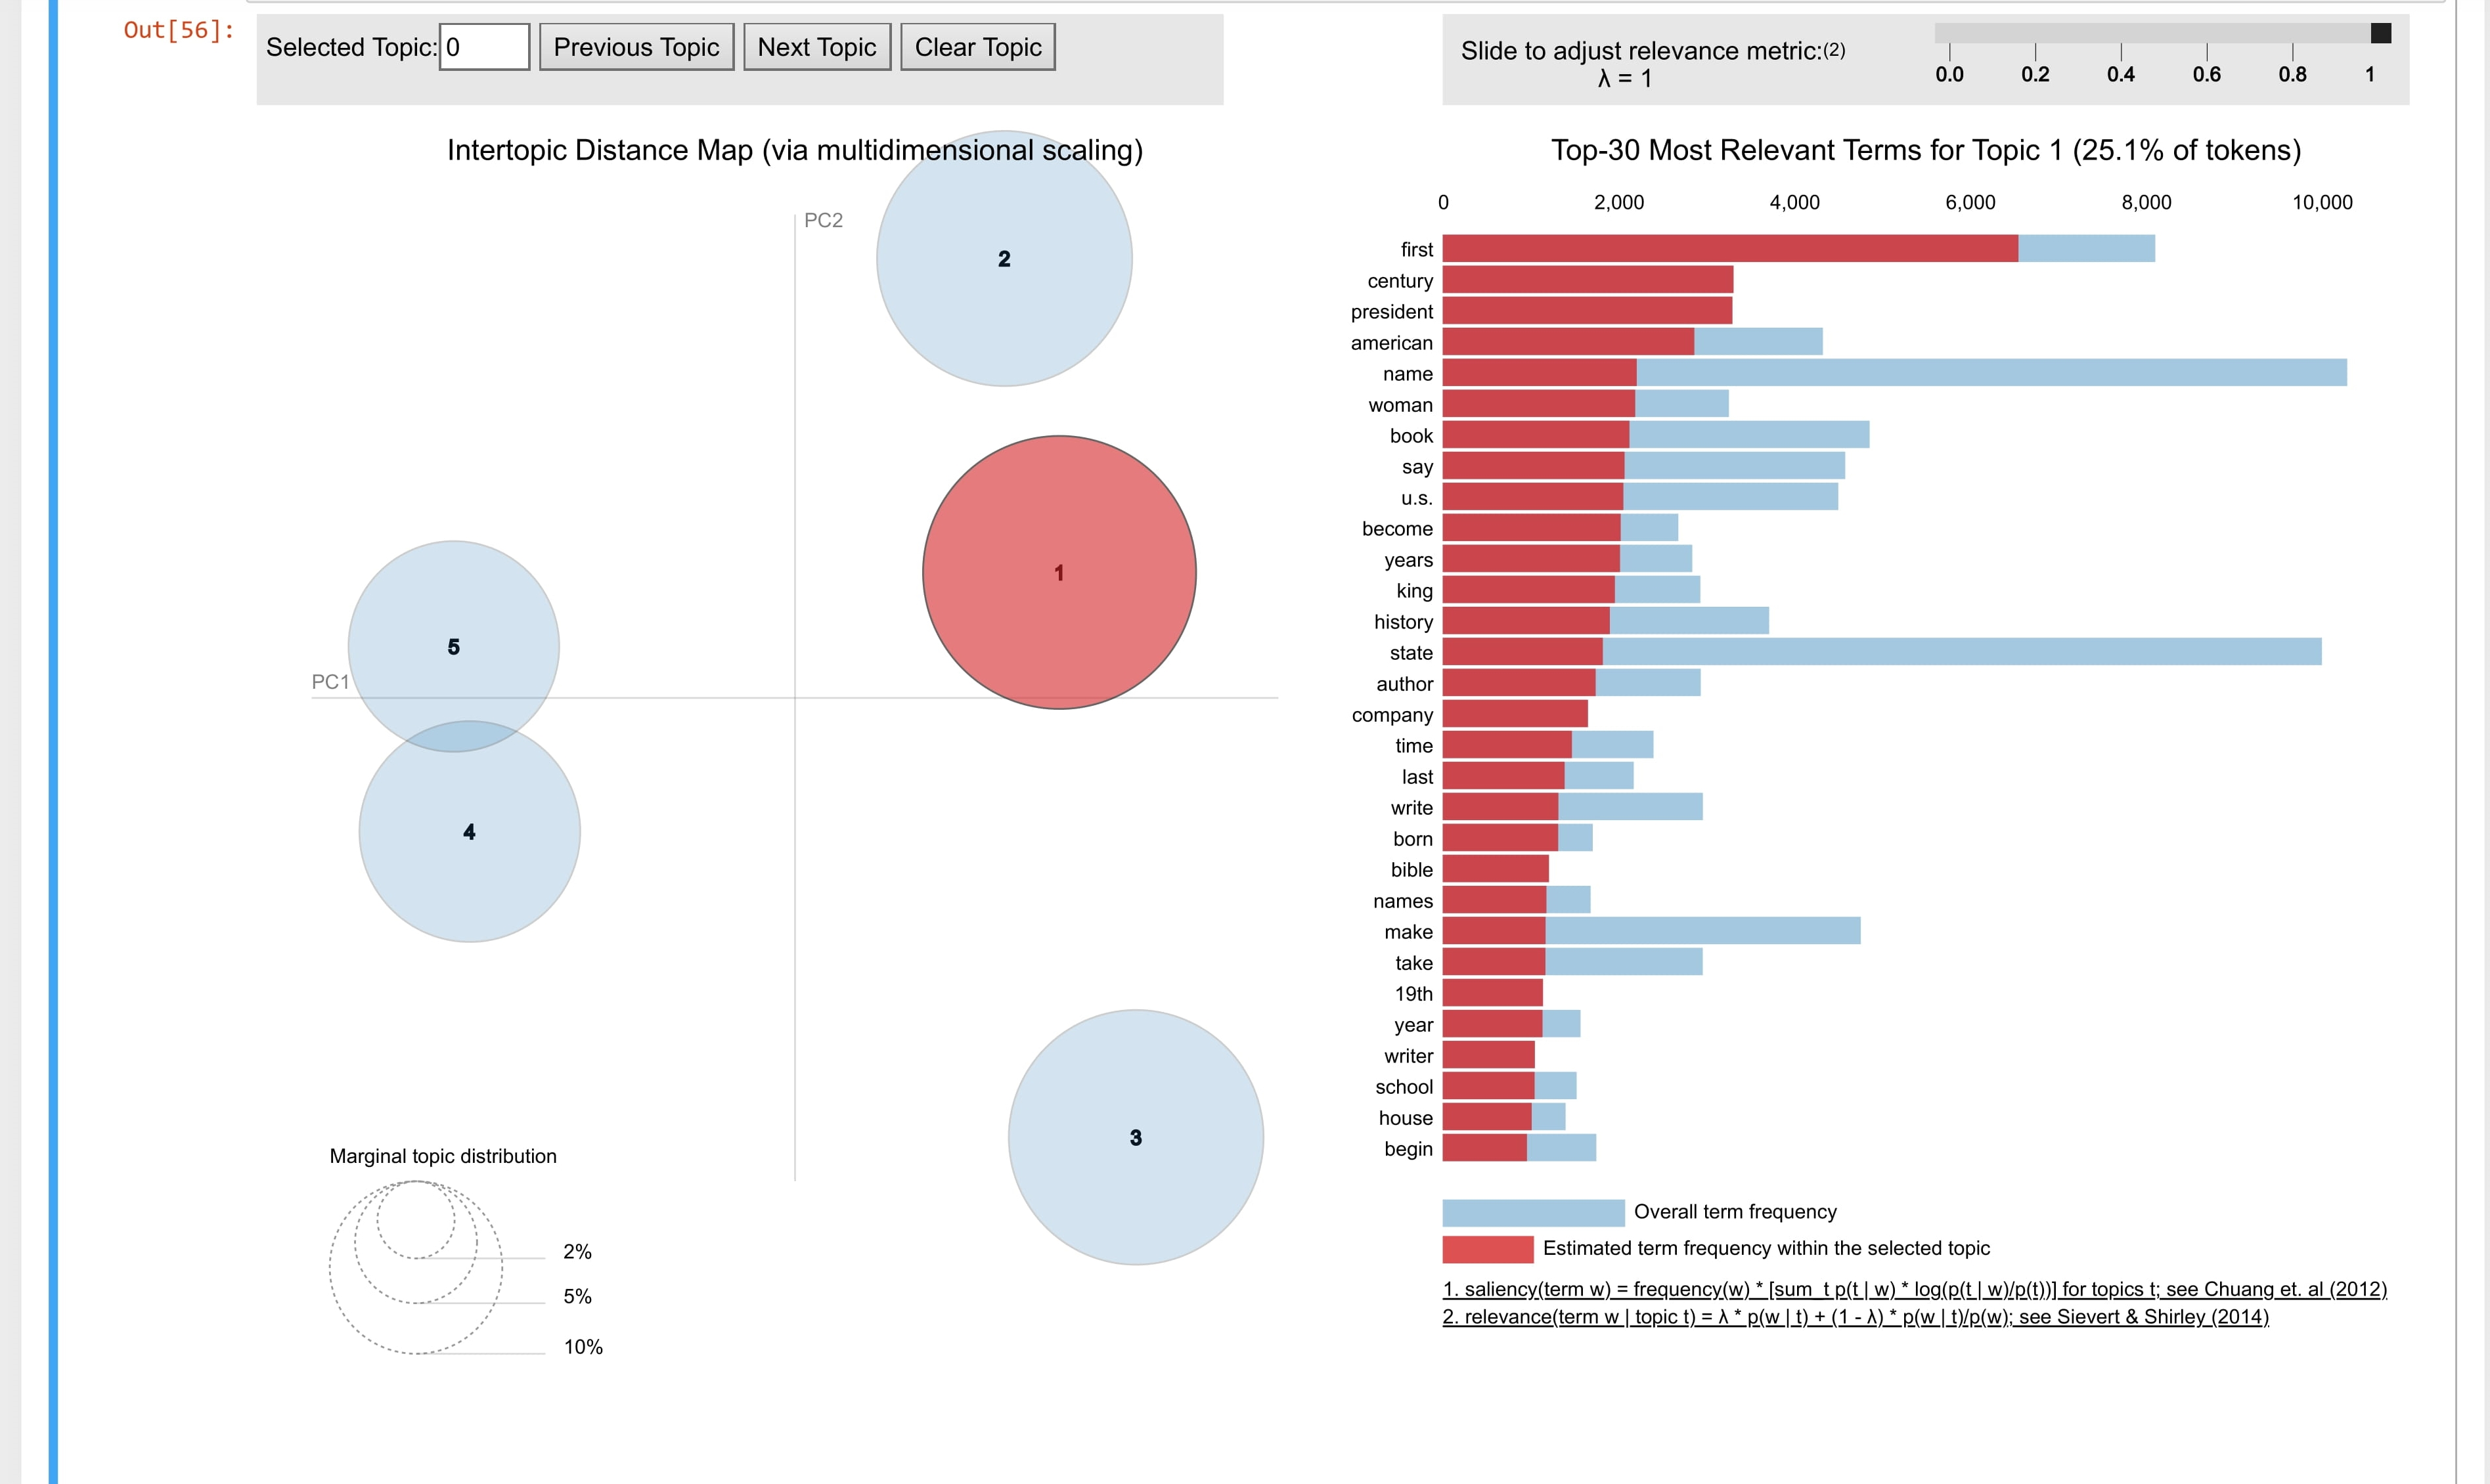

### The visualization model here is breaking down keywords into topics according to relevance and frequency. 
### The larger the circle, the more of the data the topic covers. The distance between the circles is a measure of the differences of the topics.
### This visualization is really projecting multidimensional variables into 2-dimensional space.
### We get a sense of the topics by looking at the words here in each category, although they seem to be too broad. Let's break down even further.

In [68]:
model_10_topics = pyldavis_visualize(text_data,10,5);

In [69]:
#### top 5 words of each topic returned
model_10_topics[0]

[(0,
  '0.024*"name" + 0.016*"like" + 0.014*"make" + 0.013*"This" + 0.011*"word"'),
 (1,
  '0.026*"book" + 0.025*"novel" + 0.017*"This" + 0.016*"write" + 0.016*"author"'),
 (2,
  '0.015*"country" + 0.015*"king" + 0.014*"history" + 0.010*"This" + 0.010*"British"'),
 (3,
  '0.043*"first" + 0.025*"president" + 0.023*"century" + 0.017*"become" + 0.011*"sport"'),
 (4,
  '0.062*"state" + 0.022*"island" + 0.015*"company" + 0.014*"This" + 0.013*"type"'),
 (5,
  '0.017*"name" + 0.014*"language" + 0.013*"school" + 0.013*"This" + 0.010*"family"'),
 (6,
  '0.046*"country" + 0.021*"river" + 0.018*"body" + 0.014*"long" + 0.014*"water"'),
 (7,
  '0.014*"nickname" + 0.012*"holiday" + 0.011*"Lake" + 0.010*"want" + 0.010*"African"'),
 (8,
  '0.027*"movie" + 0.026*"title" + 0.025*"film" + 0.016*"play" + 0.014*"star"'),
 (9,
  '0.073*"city" + 0.037*"capital" + 0.022*"world" + 0.020*"country" + 0.019*"state"')]

In [ ]:
model_10_topics[1]

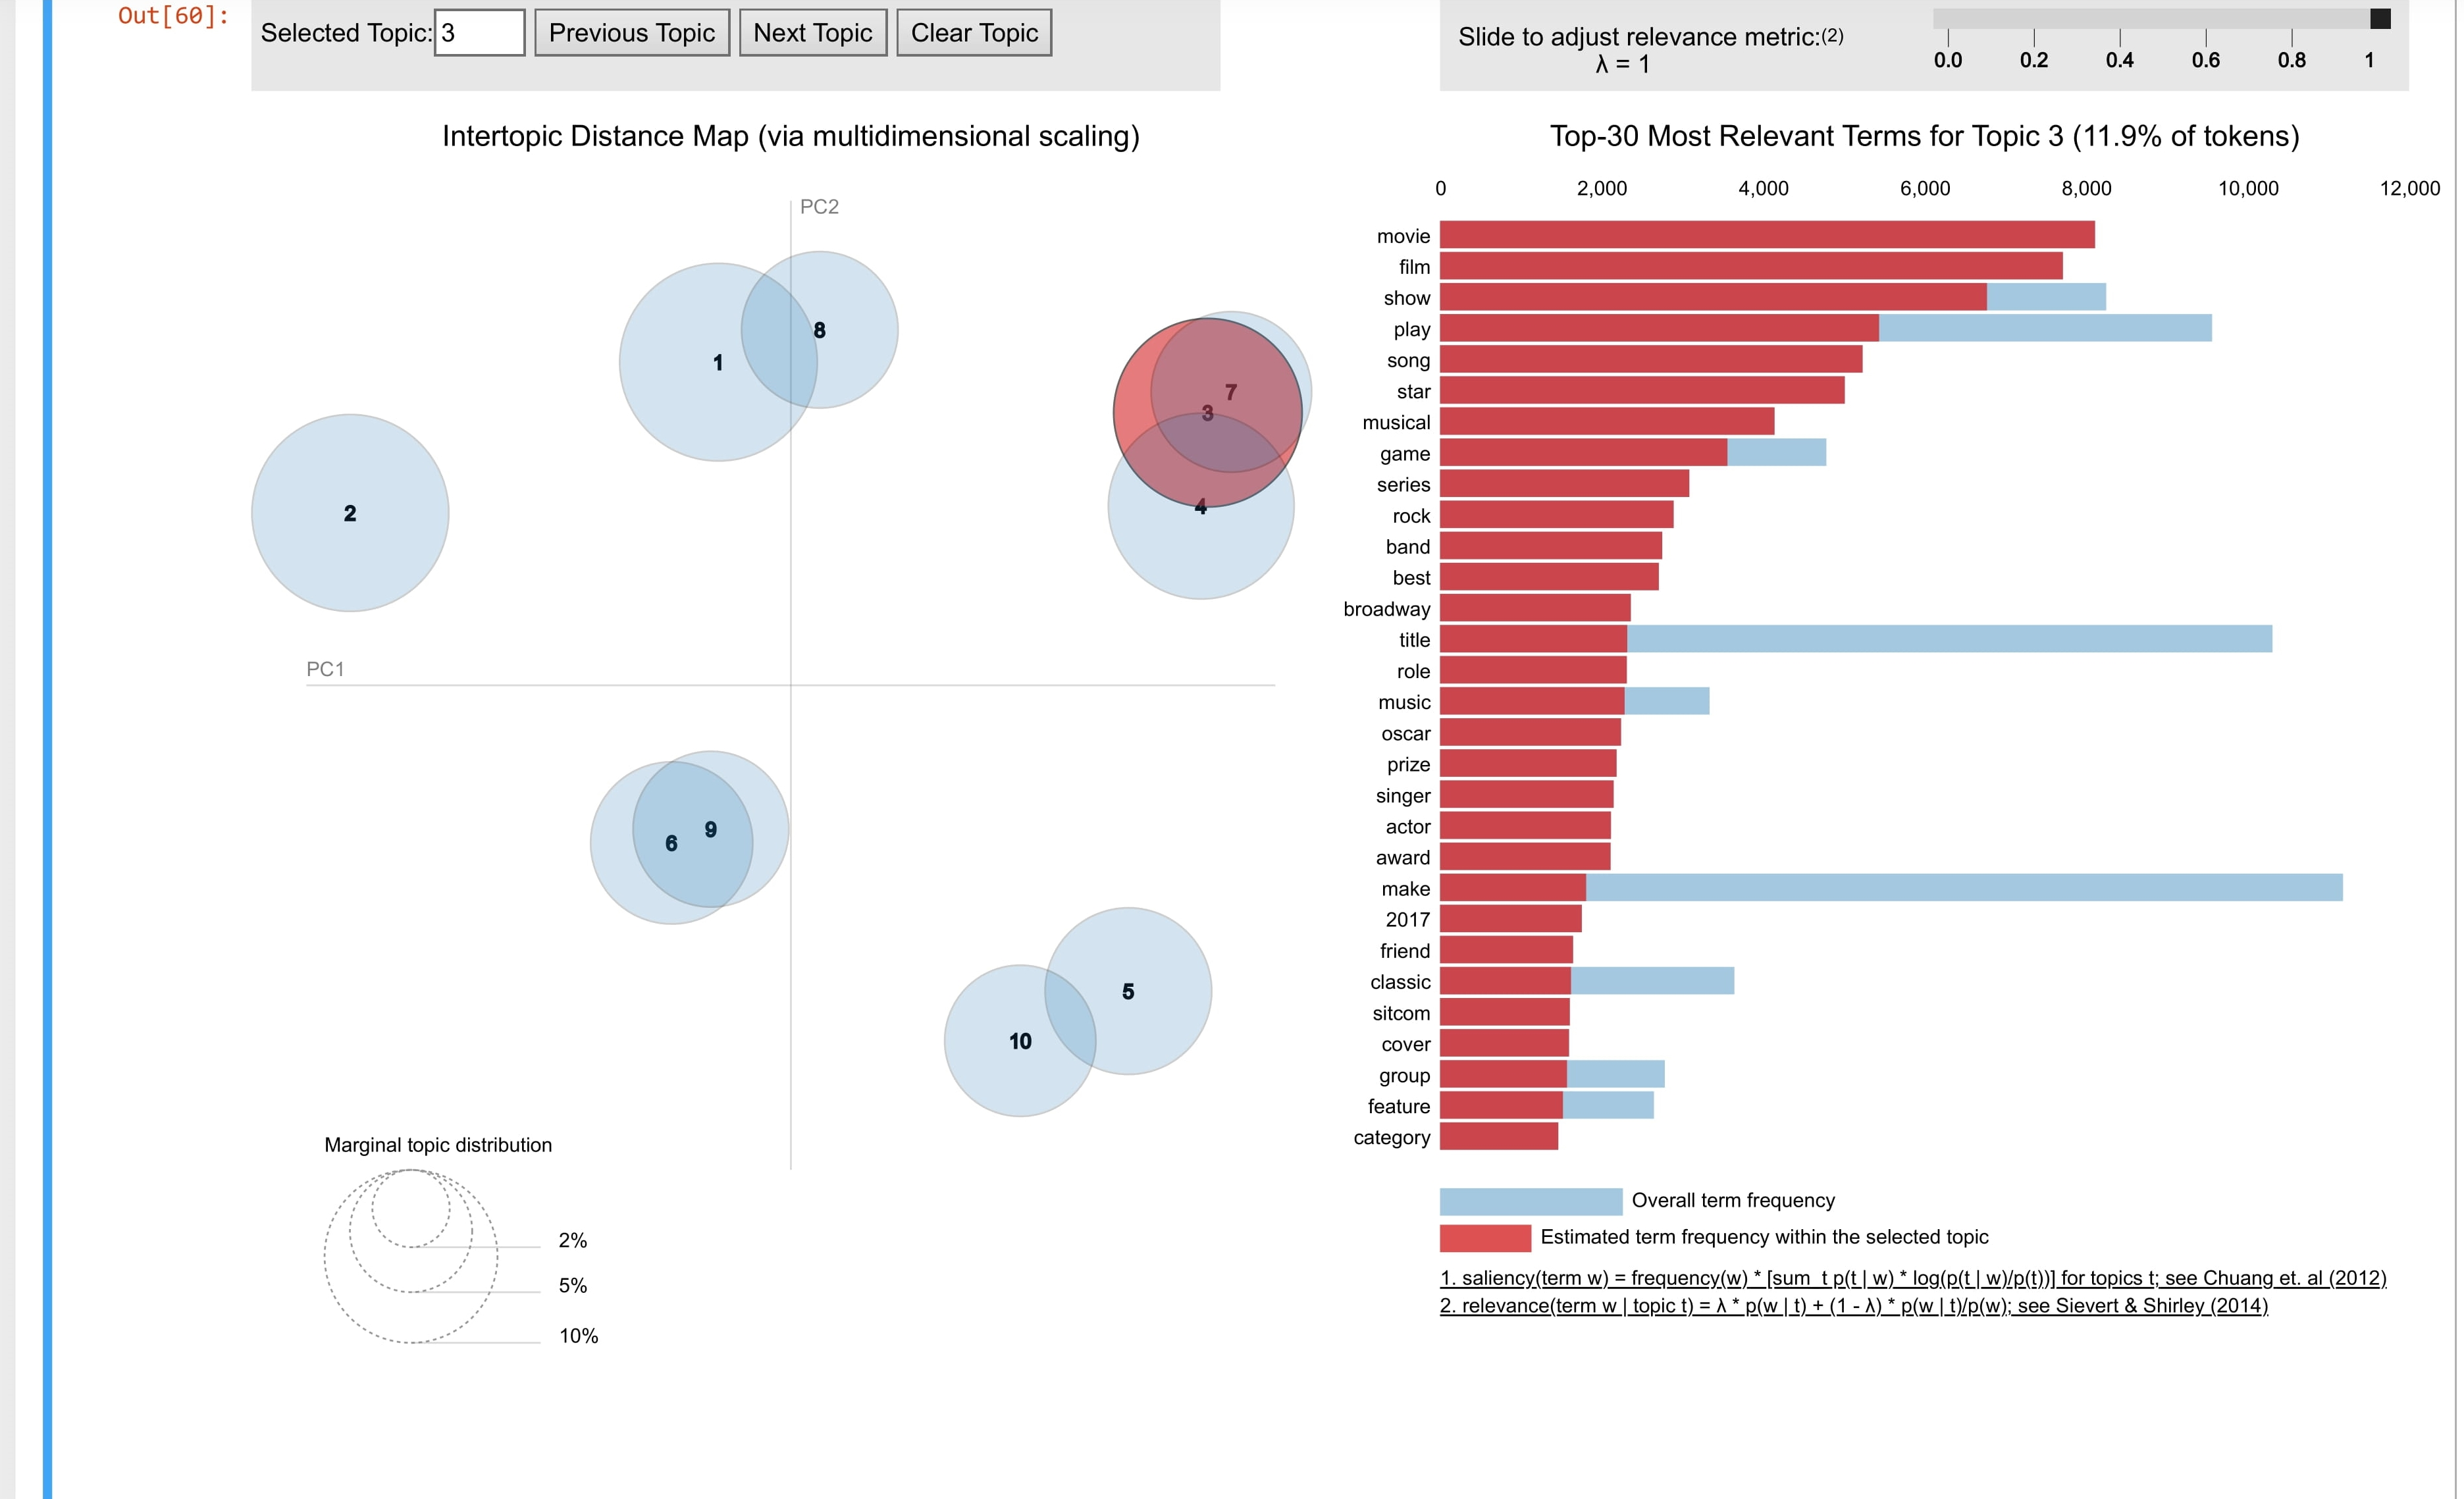

### Now we see still see topics in distinct regions but all except 1 overlap others.

In [70]:
model_20_topics = pyldavis_visualize(text_data,20,5);

In [71]:
model_20_topics[0]

[(0,
  '0.067*"include" + 0.037*"names" + 0.032*"animal" + 0.030*"love" + 0.026*"town"'),
 (1,
  '0.146*"first" + 0.045*"place" + 0.037*"woman" + 0.036*"take" + 0.029*"company"'),
 (2,
  '0.062*"century" + 0.055*"president" + 0.029*"become" + 0.022*"19th" + 0.020*"country"'),
 (3,
  '0.045*"king" + 0.027*"words" + 0.024*"kill" + 0.022*"move" + 0.021*"museum"'),
 (4,
  '0.038*"river" + 0.026*"go" + 0.025*"born" + 0.025*"long" + 0.021*"american"'),
 (5,
  '0.046*"body" + 0.045*"part" + 0.035*"water" + 0.033*"back" + 0.031*"give"'),
 (6,
  '0.129*"city" + 0.083*"country" + 0.064*"world" + 0.050*"capital" + 0.030*"This"'),
 (7,
  '0.052*"begin" + 0.025*"winner" + 0.022*"still" + 0.020*"record" + 0.017*"West"'),
 (8,
  '0.055*"like" + 0.033*"national" + 0.031*"many" + 0.024*"nickname" + 0.020*"times"'),
 (9,
  '0.036*"school" + 0.027*"family" + 0.021*"element" + 0.019*"science" + 0.019*"symbol"'),
 (10,
  '0.030*"great" + 0.029*"band" + 0.027*"border" + 0.024*"York" + 0.024*"City"'),
 (11,


In [ ]:
model_20_topics[1]

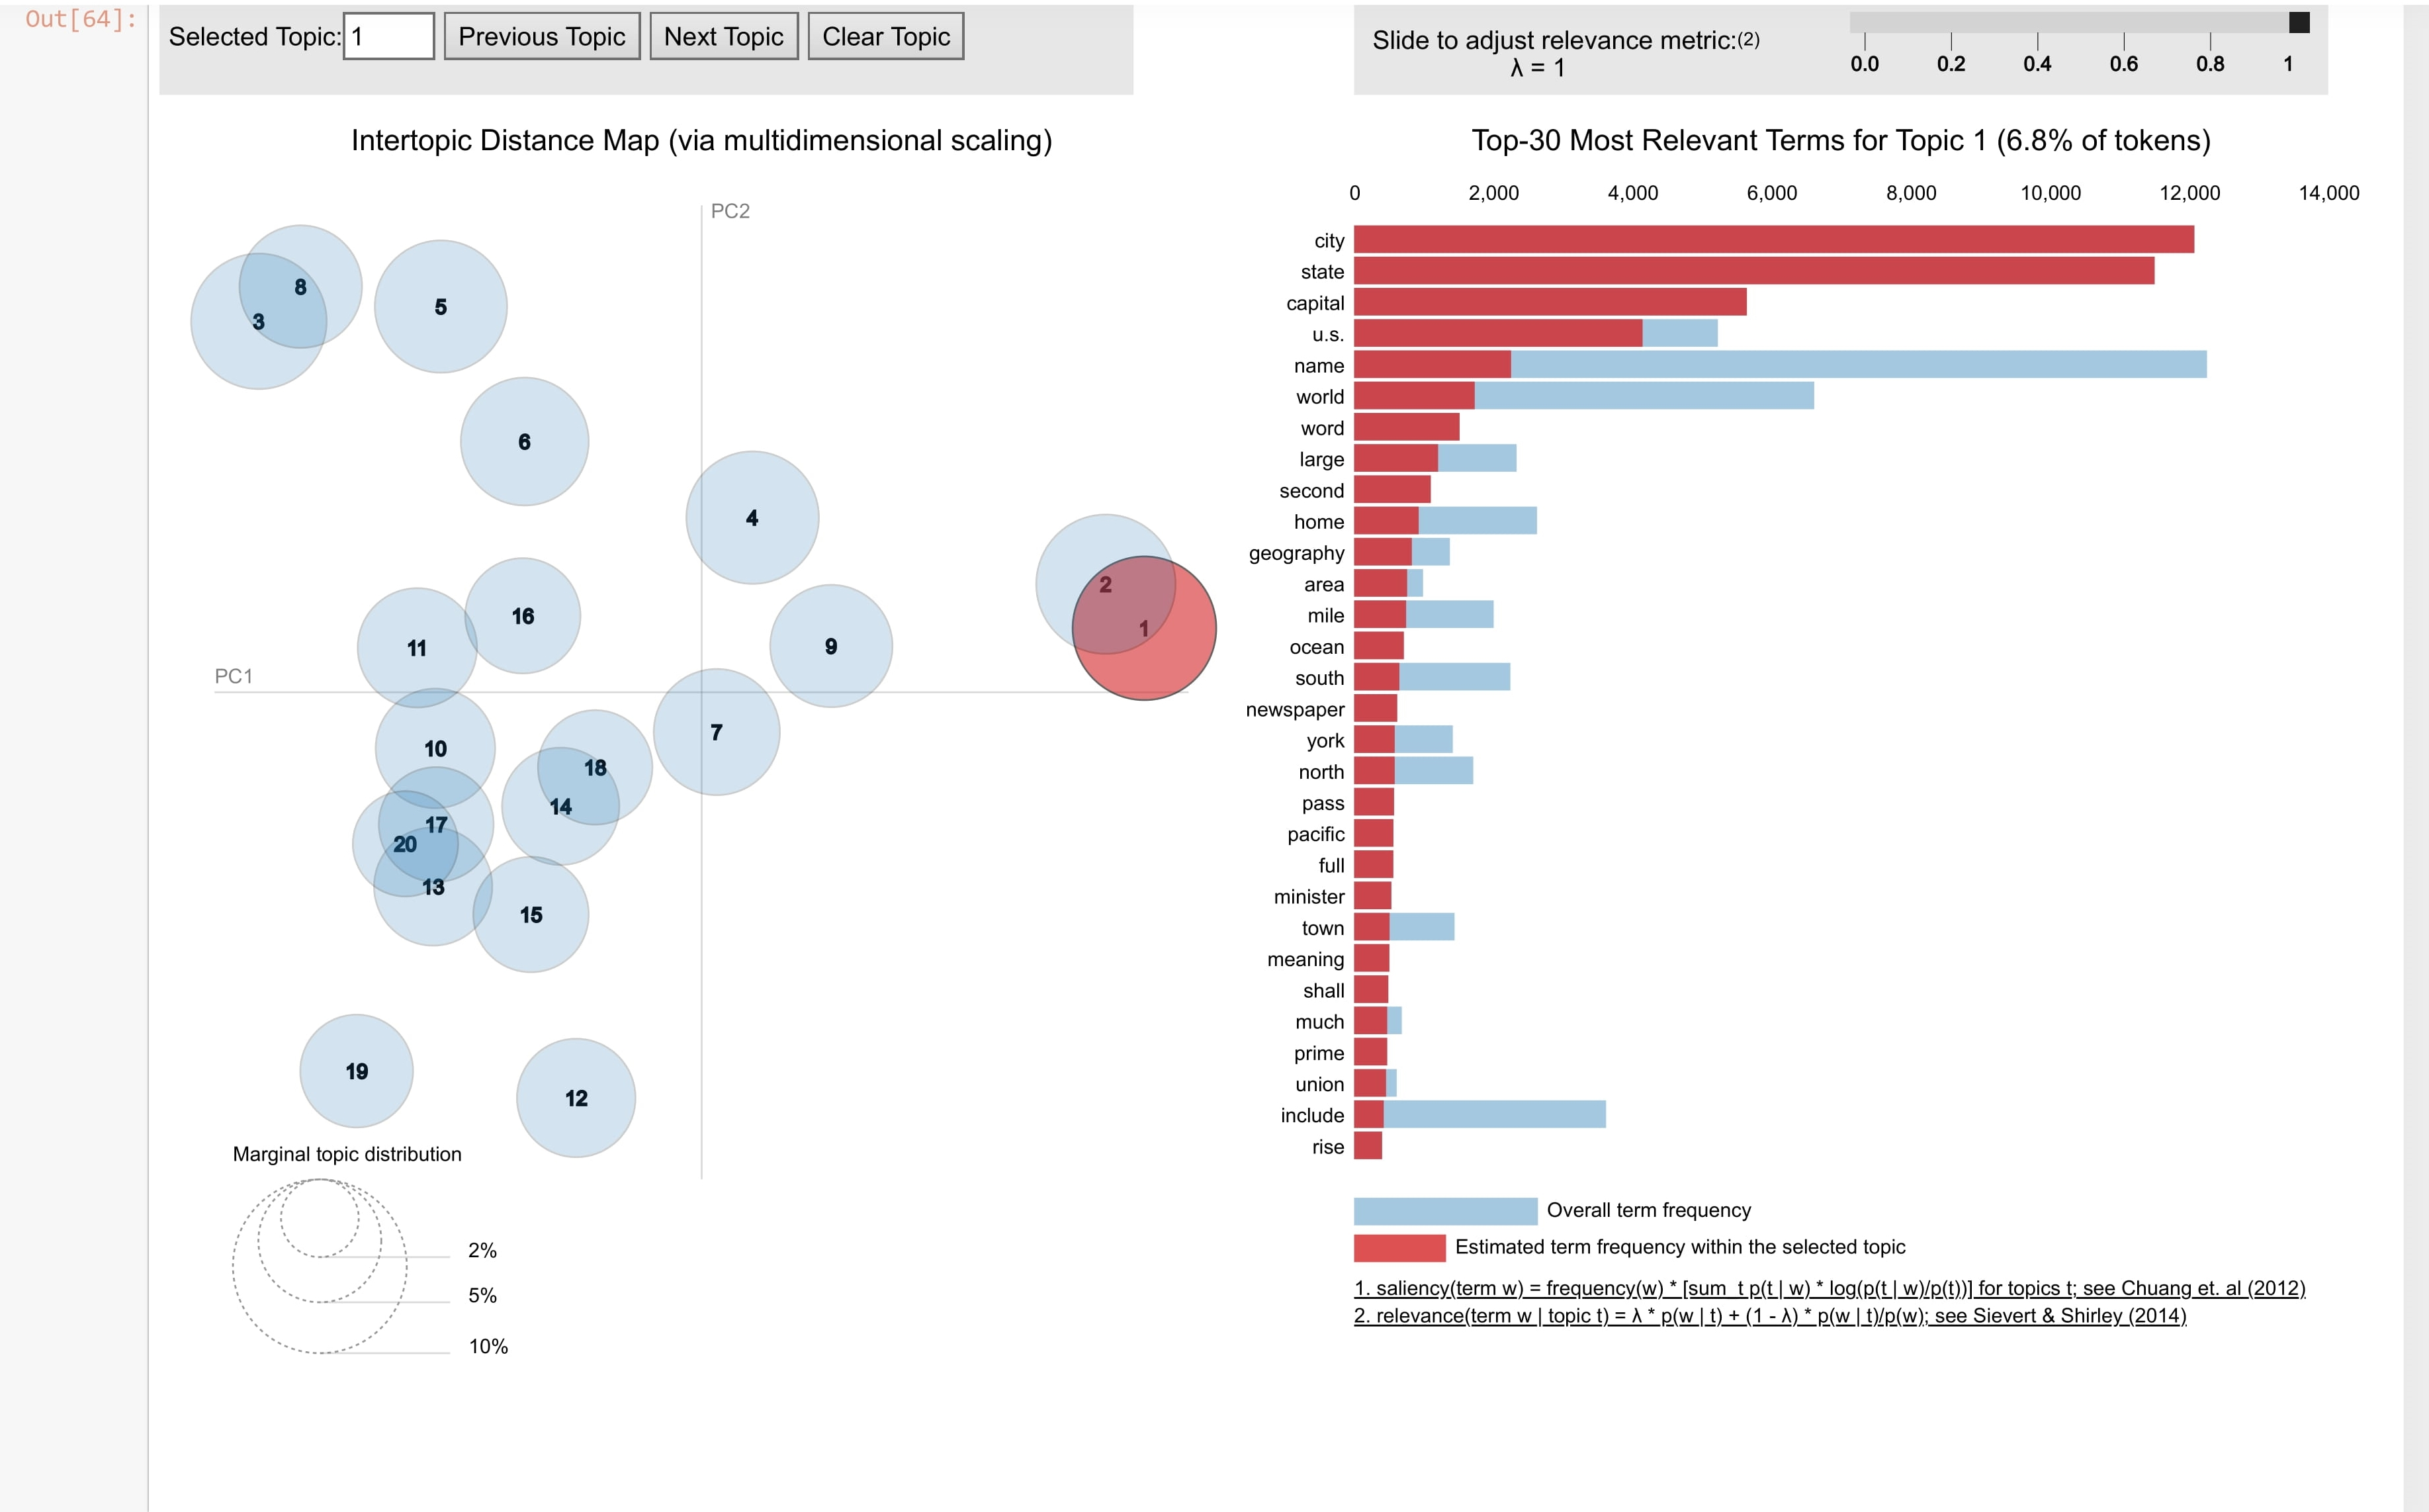

### At 20 topics we still see many distinct topics.
### We do see some overlap, but most noticeable the topics are concentrated in the leftmost 2 regions. 

### Our next step is to find the most relevant keywords associated with a particular answer and do not consider category.  We need to build a model to do that.  The topic modeling suggests it may be possible to break down keywords into distinct topics but we need to watch for overlap.

# Keyword Extraction

## Numbers refinement

### It was found that the previous analysis excluded many numbers as the prepare_text_for_lda function was removing any string with a count less than 3.
### The total rows with numbers in the question text itself is 60213.
### Some sample phrases found with numbers: season 2 of, part 3, rescued 6 years, July 26, e.g...
### For now we modified the prepare text to include all numbers because they may be important keywords themselves or part of a keyword ngram.

In [73]:
jp_top['numbers_in']  = jp_top.apply(lambda x : ','.join(re.findall('[0-9]+', x['question']) ), axis = 1);

#### 60213 rows have numbers in the question text

In [74]:
jp_top.loc[jp_top['numbers_in'] != ''].shape

(60213, 13)

## Helper functions for keyword extraction models, including Yake, Rake, Spacy entities, and Suma text rank.

In [75]:
def prepare_text_for_lda(text):
    '''
    parses a line of text and returns a list of lemmatized words which are not stopwords and whose length is greater than 3
    '''
    tokens = tokenize(text)
    ### including numbers and excluding evertyhing greater than 3 characters
    tokens = [token for token in tokens if (len(token) > 3  and not token.isnumeric())
             or token.isnumeric()]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma2(token).replace("\\","") for token in tokens]
    return tokens

In [76]:
def simple_prepare_text_for_lda(text):
    '''
    parses a line of text and returns a list of lemmatized words which are not stopwords and whose length is greater than 3
    '''
    tokens = tokenize(text)
    tokens = [get_lemma2(token).replace("\\","") for token in tokens]
    return tokens

In [77]:
def get_keywords_yake(text, n = None, df = None, dl = None, ws = None, t = None):
    '''
    extracts keywords using the yake model
    n = maxime size of ngrams
    df = de duplication function
    dl = duplication limit - from .1 to .9
    ws = windows size
    t = top number of words returned
    '''
    tokens = prepare_text_for_lda(text)
    proc_text = ' '.join(tokens)
    proc_text = proc_text.replace("\\","")
    proc_text = proc_text.replace("''","")

    proc_text = proc_text.replace("``","")
    kw_extractor = yake.KeywordExtractor(n=n, dedupFunc = df, dedupLim = dl, windowsSize = ws, top =t)
    keywords = kw_extractor.extract_keywords(proc_text)
    return (keywords, len(keywords))

In [78]:
from rake_nltk import Rake
def get_keywords_rake(text):
    '''
    extracts keywords using the rake model
    '''
    r = Rake()
   ## tokens = simple_prepare_text_for_lda(text)
   ## proc_text = ' '.join(tokens)
    r.extract_keywords_from_text(text.replace("\\",""))
    return r.get_ranked_phrases_with_scores()

In [79]:
def get_ents(text):
    '''
    extracts entities from text using the spacy model
    '''
    nlp = spacy.load("en_core_web_lg")
    tokens = prepare_text_for_lda(text)
    proc_text = ' '.join(tokens)
    doc = nlp(proc_text)
    return doc.ents

In [80]:
from summa import keywords as KeyWords
def get_keywords_suma(text):
    '''
    extracts keywords using the summa text rank model
    '''
    tokens = prepare_text_for_lda(text)
    proc_text = ' '.join(tokens)
    proc_text = proc_text.replace("\\","")
    proc_text = proc_text.replace("\\","")
    proc_text = proc_text.replace("''","")
    
    return KeyWords.keywords(proc_text).split('\n')

### create a dictionary of each unique top answer and corresponding text

In [83]:
jp_top.to_csv('../data/jp_top.csv', index = False)

In [84]:
jp_top = pd.read_csv('../data/jp_top.csv')

In [85]:
answer_groups = jp_top.groupby('answer')

In [86]:
answer_dict = dict()
for el in answer_groups.indices.keys():
    ctxt = ''
    jp_el = jp_top.loc[jp_top['answer'] == el]
    for x in jp_top.loc[jp_top['answer'] == el].index:
        txt = jp_el.loc[x]['category'] + '. ' + jp_el.loc[x]['question']
        ctxt = ctxt + '. ' + txt      
    answer_dict[el]= ctxt


#### example text for 'rent'

In [87]:
answer_dict['rent']

'. starts with "r\\". It\'s a past tense of rend, or what you pay your landlord. musical theater. This Jonathan Larson musical set in New York\'s East Village made the May 13, 1996 cover of Newsweek. musicals in other words. \\"Apartment Payment\\". name the musical. \\"Seasons of Love\\". anagrammed musicals. \\"Tern\\". word origins. From the Latin render, "to yield", it\'s something you have to yield up to your landlord. kids say the darnedest things. Mom & Dad, or what they probably don\'t make kids pay. take me to the theatre!. I could see this long-running musical over & over because I\'m nuts about the song "Seasons Of Love\\". musical theatre. (Sofia of the Clue Crew in New York City)  "Out Tonight" is performed here at the Nederlander Theatre in this Jonathan Larson musical. songs from musicals. \\"Light My Candle" & "La Vie Boheme\\". lyrical broadway. \\"525,600 minutes--how do you measure, measure a year?\\". theatrical angels. A transvestite street drummer named Angel is o

## Model Comparisons for specific phrase : 'The Taming of the Shrew'

### Below is a yake extraction model. I used max ngram 1 as that is more ideal for a word cloud format. 
### The biggest advantage of yake is it is unsupervised, and corpus and language independent.  It also considers cases of words and sentence structure.
### In addition, yake gives scores for the keywords. The lower the number, the better the score.
### shakespeare is the highest rank keyword

In [91]:
keywords = get_keywords_yake(answer_dict['the taming of the shrew'], 1, 'seqm', .3, 2, 20)
keywords[0]

[('Kate', 0.0008906038615566092),
 ('shakespeare', 0.0012082035988128566),
 ('Kiss', 0.0026620200522240595),
 ('Petruchio', 0.0031974941019038473),
 ('play', 0.0036896810343933924),
 ('comedy', 0.00476790562409269),
 ('Lucentio', 0.006654381010795196),
 ('Bianca', 0.00888487269929065),
 ('Christopher', 0.01262076841518122),
 ('musical', 0.012950383871094156),
 ('film', 0.01851616016912332),
 ('inspired', 0.02341113073220578),
 ('part', 0.025684082787180488),
 ('sex', 0.03850482177983252),
 ('house', 0.03850482177983252),
 ('actor', 0.03850482177983252),
 ('tail', 0.03943205518447309),
 ('John', 0.044835407733873935),
 ('Richard', 0.044835407733873935),
 ('Supposes', 0.044835407733873935)]

#### sample wordcloud for Yake model

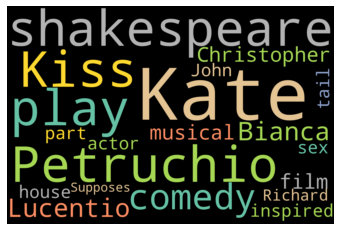

In [93]:
st = ' '.join([el[0] for el in keywords[0]])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(st)
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Below is a Spacy entitiy recognition model which picks out known names, dates, places, organizations, ...
### This relies on a trained corpus which has to be loaded
### we see it seems to pull out entities pretty well but misses non-entity keywords
### there are many duplicates which would have to be cleaned before putting in a word cloud.

In [94]:
get_ents(answer_dict['the taming of the shrew'])

(shakespeare Battle,
 Kiss Kate,
 british 1980,
 Shakespeare,
 Monty Python,
 John Cleese,
 Petruchio,
 Katharine,
 3,
 Katharina shakespearean,
 Kate,
 Kate Petruchio,
 elizabeth taylor,
 1967,
 Shakespearean,
 Richard Burton,
 George Gascoigne,
 Merry Jest Shrewd,
 Lucentio,
 Petruchio,
 Kiss Kate,
 shakespeare,
 Termagant Domestication,
 shakespeare,
 Cybill Shepherd Kate,
 Tracey Ullman,
 Helen Hunt,
 Wild West,
 1990,
 1999,
 10,
 Shakespeare,
 Kate,
 Kate,
 Lucentio Bianca Katharina,
 shakespeare Bianca,
 Kate,
 shakespeare,
 Bianca,
 Katherine,
 Padua,
 Gremio,
 Petruchio Katharina,
 1999,
 10,
 shakespeare Christopher,
 Vincentio Lucentio,
 Bisbetica Dominata,
 Shakespeare,
 Christopher Kate,
 Kate,
 Kiss Kate,
 Roger Rees,
 Bebe Neuwirth Good,
 1999,
 shakespeare quote,
 Kiss Kate,
 Sunday,
 Kate,
 Kate,
 Kate,
 shakespeare,
 10,
 Shakespeare,
 Julia Stiles,
 Kiss Kate,
 Shakespeare,
 Ford Theatre Baltimore,
 Petruchio,
 Padua,
 Katherina shakespeare,
 1,
 Kate,
 Kate,
 Kate,


### Below is a rake model which pulls out the most relevant phrases along with scores
### One advantage is tokenizing is not necessary as rake already has predefined stopwords in its model and considers punctuation.
### Like the Spacy, there are duplicate single words which would have to be cleaned up but filtering based on scores could be a good way to limit the number of words for the word cloud.

In [95]:
s = get_keywords_rake(answer_dict['the taming of the shrew'])
s

[(23.5, 'somewhat unpleasant sister named katherine'),
 (22.0, '” john cleese played petruchio'),
 (20.071428571428573, 'one small burrowing mammal ".'),
 (17.960317460317462, 'shakespeare play “ monty python'),
 (16.5, 'single girl named katherina'),
 (15.0, 'moonlighting ", cybill shepherd'),
 (13.571428571428571, 'shakespeare -- act ii'),
 (11.5, 'tail ", says petruchio'),
 (9.0, 'stars julia stiles'),
 (9.0, 'roger rees tried'),
 (9.0, 'la bisbetica dominata'),
 (9.0, 'good luck !)'),
 (9.0, 'external parts ?"'),
 (9.0, 'domesticate bebe neuwirth'),
 (8.772727272727273, 'prithee sister kate'),
 (8.666666666666666, '1980 bbc production'),
 (8.333333333333334, '1999 teen flick'),
 (8.095238095238095, 'shakespearean last scenes'),
 (8.0, 'gradually easier character'),
 (8.0, 'curst wife ...".'),
 (7.928571428571429, 'shakespearean scene settings'),
 (7.666666666666667, 'elizabeth taylor films'),
 (7.666666666666666, 'set 1990 production'),
 (7.595238095238095, 'shakespearean last line

### Below is a Suma model based on a text ranked algorithm which is graphical in nature.
### Like yake, one advantage is this is corpus independent 
### It is also simple in that it just identifies what is a keyword or not.

In [96]:
get_keywords_suma(answer_dict['the taming of the shrew'])

['shakespeare',
 'play',
 'played',
 'kate based',
 'comedy',
 'petruchio shakespearean',
 'lucentio',
 'bianca',
 'musical',
 'kiss',
 'character',
 'production',
 'katharina',
 'domestication',
 'domesticate',
 'curst',
 'film',
 'come',
 'christopher',
 'named',
 'things',
 'wild',
 'sister',
 'tail',
 'jest',
 'jested',
 'bawdy',
 'word',
 'actor',
 'title',
 'setting',
 'say',
 'scene',
 'gremio',
 'starred',
 'star',
 'actually',
 'line']

### Comparison for General Phrase : 'Atlantic Ocean'

### One thing to notice for the yake model for a more general type of answer is that the numbers are generally higher than the previous example

In [97]:
keywords = get_keywords_yake(answer_dict['atlantic ocean'], 1, 'seqm', .3, 2, 20)
keywords[0]

[('Ocean', 0.006969369612252553),
 ('body', 0.008371190810315728),
 ('water', 0.008371190810315728),
 ('current', 0.018571507180212783),
 ('Lindbergh', 0.023781994953609456),
 ('Coast', 0.0282977780739743),
 ('amazon', 0.03097912771249847),
 ('world', 0.04442276639237885),
 ('flow', 0.04442276639237885),
 ('John', 0.04792949052347535),
 ('Pacific', 0.04792949052347535),
 ('Rock', 0.04792949052347535),
 ('Bermuda', 0.04792949052347535),
 ('Triangle', 0.04792949052347535),
 ('Sailing', 0.04792949052347535),
 ('Weddell', 0.04792949052347535),
 ('Charles', 0.04792949052347535),
 ('Capsized', 0.04792949052347535),
 ('Bank', 0.04792949052347535),
 ('exotic', 0.08650365936294595)]

### the entity model produces a much smaller list than the previous example

In [98]:
get_ents(answer_dict['atlantic ocean'])

(8 year,
 Lindbergh,
 John Alcock,
 Whitten Brown,
 Ocean Ivory Coast,
 Pacific,
 Madeira Rock Garden ocean ocean,
 Titan,
 Brazil,
 Bermuda Triangle,
 Namibia,
 second,
 second,
 america,
 Orinoco,
 Weddell Antarctic Ocean,
 Charles Lindbergh,
 1927,
 H.M.S Titanic,
 Peru,
 Amazon,
 4,000 mile,
 Capsized Georges Bank,
 Ernie Hazard,
 2 day)

### The rake model returns less phrases with scores of greater than 9 compared to the prior example

In [99]:
get_keywords_rake(answer_dict['atlantic ocean'])

[(36.0, 'mysterious bermuda triangle region lies within'),
 (25.0, 'ernie hazard survived 2 days'),
 (16.0, 'arthur whitten brown crossed'),
 (9.0, 'several currents flow'),
 (8.0, 'charles lindbergh made'),
 (4.0, 'watery grave'),
 (4.0, 'species named'),
 (4.0, 'south america'),
 (4.0, 'rock garden'),
 (4.0, 'may 1927'),
 (4.0, 'labrador current'),
 (4.0, 'john alcock'),
 (4.0, 'georges bank'),
 (4.0, 'flew solo'),
 (4.0, 'exotic flowers'),
 (4.0, 'drainage area'),
 (4.0, 'brazil current'),
 (4.0, '8 years'),
 (4.0, '000 miles'),
 (3.5, 'world geography'),
 (3.5, 'weddell sea'),
 (3.5, 'second largest'),
 (3.5, 'others say'),
 (3.5, 'name back'),
 (3.5, 'ivory coast'),
 (3.5, 'cod caught'),
 (3.5, 'amazon flows'),
 (3.5, '4 times'),
 (3.25, 'largest body'),
 (3.166666666666667, 'larger ocean'),
 (3.166666666666667, 'antarctic ocean'),
 (3.1, 'water nonstop'),
 (2.0, 'lindbergh'),
 (1.5, 'world'),
 (1.5, 'second'),
 (1.5, 'sea'),
 (1.5, 'say'),
 (1.5, 'name'),
 (1.5, 'cod'),
 (1.5, 'c

### Again, the suma model produces a much smaller list of keywords

In [100]:
get_keywords_suma(answer_dict['atlantic ocean'])

['ocean',
 'body water',
 'lindbergh',
 'survival',
 'survived',
 'current flow',
 'titanic amazon',
 'titan world',
 'year',
 'time large',
 'region',
 'flower tree']

## Summary

We compared some of the most popular models out there and as a result have a variety of models to use for the final output.  One of the shortcomings is that there is really no standard metric evaluation to utilize that can compare results from different models on a new and untrained data set.  We can do some statistical evaluations and sensitivity analysis on single models though. For now we are going to analyze the YAKE extraction model using different hyperparameters and see if this model produces a unique set of keywords through conducting 2 sample t-tests and comparing the p-values for different thresholds.

## Model Evaluation

First we prepare some helper functions to assist us in our evaluation

In [102]:
def prepare_stemmed_text(text):
    '''
    parses a line of text and returns a list of stemmed words which are not stopwords and whose length is greater than 3
    '''
    tokens = tokenize(text)
    ### including numbers and excluding evertyhing greater than 3 characters
    tokens = [token for token in tokens if (len(token) > 3  and not token.isnumeric())
             or token.isnumeric()]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_stem(token).replace("\\","") for token in tokens]
    return tokens

In [105]:
def eval_answer_yak(answer,n = None, df = None, dl = None, ws = None, t = None):
    '''
    this function extracts keywords from a YAKE extraction model and computes
    a score based on the scoring of the individual keywords for all questions where 
    at least 1 of the keywords is present. If no keyword is present, the score is 0.
    The scores are inverted and summed so that a higher score equates to a better result.
    A question where the answer matches the input is labeld 'True', otherwise 'False'.
    All keywords are stemmed before evaluation.
    
    The inputs are the answer phrase to test, along with the same parameters used for the get_keywords_yake function.
    
    The returns are the keywords, the questions and scores of the 'true results',
    and the questions and scores of the 'false results'
    
    '''
    keywords = get_keywords_yake(answer_dict[answer], n, df, dl, ws, t)[0]
    
    ## if answer appears in keywords, remove it
    for i, el in enumerate(keywords):
        if el[0].lower() == 'answer':
            keywords.pop(i)
    keywords_dict = {get_stem(y[0]):y[1] for x,y in enumerate(keywords)}
    true_answers = pd.DataFrame(jp_top.loc[jp_top['answer'] == answer][['category','question']])
    false_answers = pd.DataFrame(jp_top.loc[jp_top['answer'] != answer][['category','question','answer']])
    true_answers['score'] = 0
    false_answers['score'] = 0
    for i in true_answers.index:
        score = 0
        st = set(prepare_stemmed_text(true_answers['category'][i] + ' ' + true_answers['question'][i]))
        for word in st:
            if word in keywords_dict.keys():
                score += 1/keywords_dict[word]
        true_answers['score'][i] = score
    
    for i in false_answers.index:
        score = 0
        st = set(prepare_stemmed_text(false_answers['category'][i] + ' ' + false_answers['question'][i]))
        for word in st:
            if word in keywords_dict.keys():
                score += 1/keywords_dict[word]
        false_answers['score'][i] = score  
    
    return (keywords,true_answers,false_answers)

### Here we are analyze the counts of our top answers and their distribution.

In [148]:
jp_top['answer'].value_counts().describe()

count    5168.000000
mean       27.227167
std        26.311864
min        12.000000
25%        14.000000
50%        19.000000
75%        29.000000
max       327.000000
Name: answer, dtype: float64

<AxesSubplot:ylabel='Frequency'>

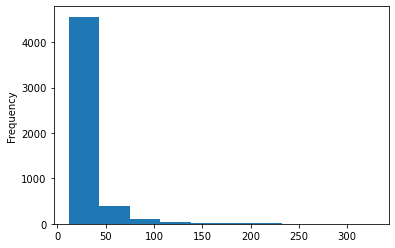

In [149]:
jp_top['answer'].value_counts().plot(kind='hist')

### We see the average count is 27, the median is 19, and that the distribution is left-skewed.

### First we will look at Alaska which has one of highest counts at 260

In [111]:
alaska = eval_answer_yak('alaska',1, 'seqm', .3, 1, 20)

In [112]:
### keywords and scores returned
alaska[0]

[('state', 0.00040928059561856194),
 ('national', 0.004016764084616087),
 ('park', 0.0056165742890657505),
 ('Sitka', 0.009223329504588509),
 ('north', 0.016146175209869256),
 ('largest', 0.0163265818889743),
 ('Arctic', 0.016925292619004034),
 ('land', 0.017409882369072545),
 ('Russia', 0.022007674005116367),
 ('mile', 0.022911717052168122),
 ('territory', 0.023840715858670775),
 ('Glacier', 0.029004124790483272),
 ('Denali', 0.029688252630140872),
 ('mountain', 0.03209286010523874),
 ('Elias', 0.03555611146318406),
 ('Yukon', 0.0429961324103831),
 ('include', 0.06513658968455603),
 ('gold', 0.0666252569749738),
 ('January', 0.08268409027283305),
 ('Tlingit', 0.08645889343095975)]

In [113]:
alaska_true = alaska[1]
alaska_false  = alaska[2]

In [114]:
### top 50 questions by score of the Alaska 'True' set
alaska_true.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
alaska_true.head(50)

category  \
87605                        south park   
92449                  historic america   
140469            visit a national park   
73464                    national parks   
64056                    national parks   
100022                      u.s. states   
49261                     at last count   
1276                     national parks   
10906                    u.s. geography   
95162                 the state it's in   
91230                state the landmark   
20099                    national parks   
111136          state the national park   
138297                      this & that   
22357                             parks   
44284                       state facts   
16780                        the u.s.a.   
90010   have you driven a fjord lately?   
71555                  national forests   
23733                national monuments   
85196        may the forest be with you   
137056                      state lines   
132194   congressional committee chairs   
62062                   national things   
18466                       survey says   
70966           the lone representative   
85138                      archipelagos   
34304                       u.s. states   
28668                    u.s. geography   
56113                       state trees   
39166                       state trees   
19953         jeopardy! state nicknames   
102890         states' first newspapers   
131720                        districts   
118632                      borough in!   
60668                       the big day   
84610                ain't that america   
64477                              1867   
20868                    u.s. geography   
8977                             rivers   
44693                       u.s. states   
34768                 the north pacific   
81676                 state song lyrics   
93080              i'm in such a state!   
57028                             flags   
11675                  american history   
7025                     u.s. geography   
49644                           america   
84583                    check your oil   
82835                     u.s. congress   

                                                                                                                                  question  \
87605                                                              National parks in the south of this state include Sitka and Glacier Bay   
92449                             A fine collection of Haida & Tlingit totem poles was toted to Sitka National Historic Park in this state   
140469                                              Denali Park & Preserve has 6 million acres of wild land & a 20,000' peak in this state   
73464                                                          The USA's largest national park in area is Wrangell-St. Elias in this state   
64056                    This state's Wrangell-St. Elias National Monument was upgraded to park in 1980 & is the USA's largest park system   
100022                           America's largest national park, Wrangell-St. Elias, covers more than 8 million acres in this large state   
49261                                                The 3 largest U.S. national parks, totaling about 20 million acres, are in this state   
1276                                                                                   The state with the largest number of national parks   
10906                                                                              Gates of the Arctic National Park is in this U.S. state   
95162                                                                                The Koyukuk Valley, Gates of the Arctic National Park   
91230                                                                  The Mendenhall Glacier, Klondike Gold Rush National Historical Park   
20099                                                     Glacier National Park is in Montana & Glacier Bay National Park is in this 

In [115]:
### top 50 questions by score of the Alaska 'False' set
alaska_false.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
alaska_false.head(50)

category  \
61400               national park place   
91694                        red states   
109672          state the national park   
32090          north american geography   
87604                        south park   
128936         the national park system   
61398               national park place   
72181                     the 50 states   
90088            states' highest points   
94310                         road test   
111139          state the national park   
68216                       on location   
26453                    state capitals   
133674                            logan   
12679                    u.s. geography   
34302                       u.s. states   
50423                    national parks   
131468            geographic formations   
61401               national park place   
24540                    national parks   
140470            visit a national park   
82095               states of the union   
71376           a wealth of information   
24401                    u.s. geography   
11224                       u.s. states   
103417               the sunshine state   
22997                  travel & tourism   
29088                    national parks   
97291         stately botanical gardens   
104715                    \"aw", shucks   
5026                              parks   
109671          state the national park   
11684                           forests   
127302                   national parks   
61399               national park place   
73260               states of the union   
61397               national park place   
120464                       california   
127767  states that begin with californ   
62054                            mounds   
89991              your state is parked   
96118           state the national park   
18886                    national parks   
127304                   national parks   
111135          state the national park   
40265                   name that state   
111137          state the national park   
111138          state the national park   
89044               international parks   
19702                              1899   

                                                                                                                          question  \
61400                                Olympic National Park in this northwest state offers mountains, glaciers & the occasional elk   
91694               If you're visiting Glacier National Park in this state, be sure to check out Red Mountain & Red Eagle Mountain   
109672                                                                                                North Cascades National Park   
32090                               Joshua Tree National Monument near Palm Springs in this state was made a national park in 1994   
87604                                  Everglades National Park in this Southern state is the USA's largest subtropical wilderness   
128936                                                This Florida park is the largest subtropical wilderness in the United States   
61398                   The largest national park outside Alaska, Death Valley National Park in this state is over 3 million acres   
72181                                    National Battlefield Parks include Manassas in Virginia & Kennesaw Mountain in this state   
90088                                                                 Boundary Peak, about 50 miles east of Yosemite National Park   
94310              John D. Rockefeller Jr. financed miles & miles of beautiful carriage roads in this state's Acadia National Park   
111139                                                                                                                     Glacier   
68216                 The 1954 Barbara Stanwyck movie "Cattle Queen of" this state was filmed on location in Glacier National Park   
26453                                                    Mendenhall Glacier & Glacier Bay Natio

### We can see that the 'false' set has questions with high scores similar to the high scores of the 'true set'
### One key observation is that the 'false' set answers are in related categories, mostly just other US states.

In [119]:
alaska_true['score'].mean()

2310.2076923076925

In [117]:
alaska_false.loc[alaska_false['score'] > 0]['score'].mean()

1023.1253707823507

### We also see that the average score of the true set is twice that of the false set and from the distributions below that the true set is skewed towards higher scores and the false set towards lower scores.

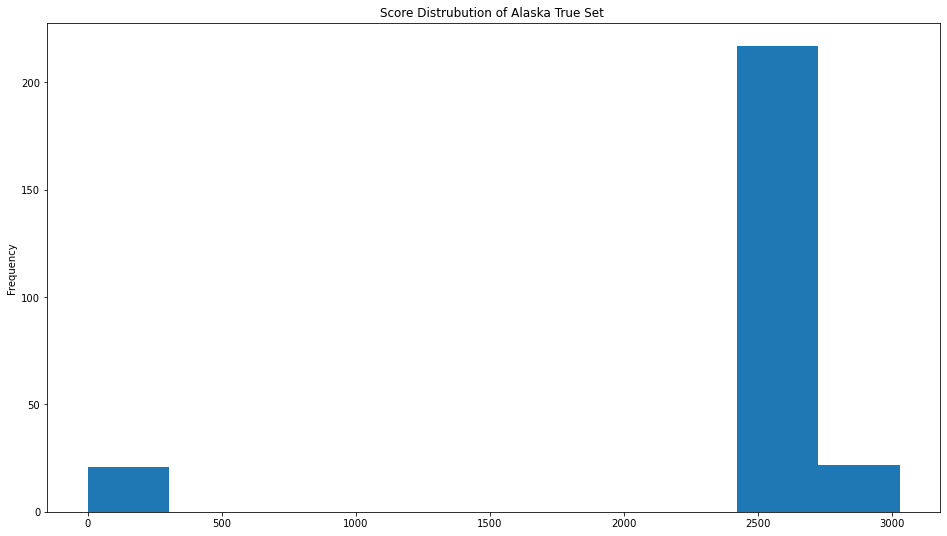

In [121]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Alaska True Set')
alaska_true['score'].plot(kind = 'hist', bins = 10);

<AxesSubplot:title={'center':'Score Distrubution of Alaska False Set'}, ylabel='Frequency'>

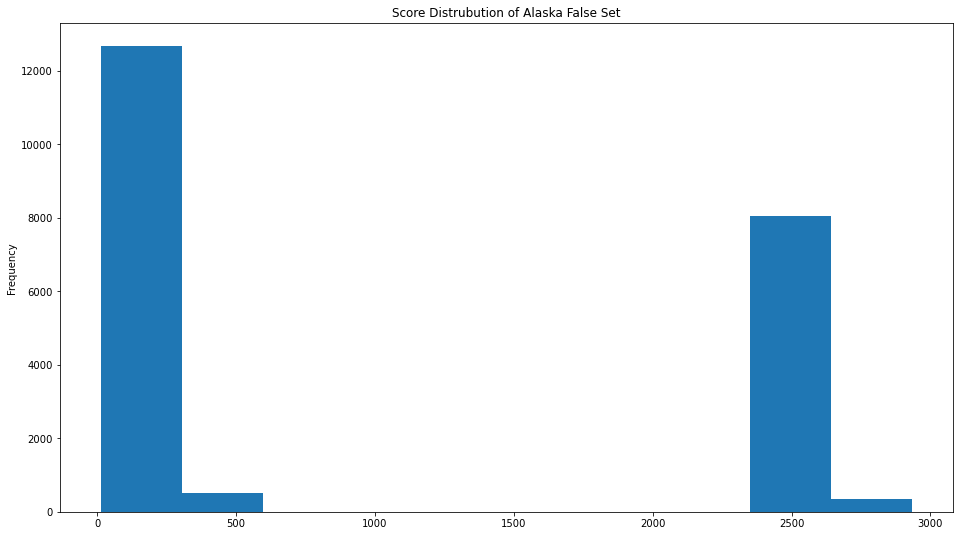

In [122]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Alaska False Set')
alaska_false.loc[alaska_false['score'] > 0]['score'].plot(kind = 'hist', bins = 10)

### Now we look at 'ptolemy' whose answer count is 30, much closer to the average

In [132]:
ptolemy = eval_answer_yak('ptolemy',1, 'seqm', .3, 1, 20)

In [161]:
ptolemy[0]

[('egypt', 0.027419915714256584),
 ('Almagest', 0.028317912446368967),
 ('astronomer', 0.03269432137582581),
 ('Greek', 0.04685224743418599),
 ('Alexandrian', 0.05690860505413572),
 ('Earth', 0.05700033711941509),
 ('century', 0.05705299556845395),
 ('Handy', 0.0735533290071721),
 ('Tables', 0.0735533290071721),
 ('work', 0.08248859276564198),
 ('map', 0.0877098595953374),
 ('universe', 0.14010151302352844),
 ('dynasty', 0.1675611476113608),
 ('moon', 0.21240205819778205),
 ('Renaissance', 0.2161393099629133),
 ('surviving', 0.23300242259959608),
 ('died', 0.23300242259959608),
 ('completed', 0.23300242259959608),
 ('Mathematike', 0.28659626702253493),
 ('system', 0.33424440019458196)]

In [133]:
ptolemy_true = ptolemy[1]
ptolemy_false  = ptolemy[2]

In [134]:
ptolemy_true.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
ptolemy_true.head(50)

category  \
30932                astronomy   
1310               2nd century   
41611                astronomy   
69764                     maps   
140443          men of science   
16006        famous scientists   
49547             seeing stars   
106956              scientists   
56172        ancient egyptians   
7895                      maps   
115571                      pi   
64489   \"p"science & medicine   
91490              astronomers   
76440      alexander the great   
13349            ancient egypt   
18626                  history   
74561              silent "p\"   
124608             history 101   
69519                cleopatra   
35970         they're history!   
87815                 the moon   
72762               stargazers   
48323           that's history   
24842              cartography   
118894         ancient science   
93539            zodiac arrest   
11916                  royalty   
114207           weird history   
62060          history speaks!   
134223      history near & far   

                                                                                                                    question  \
30932                In the "Almagest", this 2nd century Greek astronomer suggested the Earth was the center of the universe   
1310                               \"Handy Tables", "Harmonica", & "The Almagest" are among this astronomers surviving works   
41611                          This Alexandrian astronomer discusses eclipses in book VI of his 2nd century work "Almagest\"   
69764                 In about 150 A.D. this Greek astronomer in Egypt published "Geography", an 8-volume guide to mapmaking   
140443                             The "system" named for this Greek astronomer puts the Earth at the center of the universe   
16006                        Our main source of knowledge of Greek astronomy is his "Almagest", completed in the 2nd century   
49547                            Around 150 A.D. this Egyptian astronomer cataloged over 1,000 stars in his work "Almagest\"   
106956                   In the 2nd century this Alexandrian astronomer catalogued 47 of the 88 constellations we know today   
56172                      In his work "Mathematike Syntaxis", this astronomer wrongly claimed that the Earth was stationary   
7895                                       Until the 1500s maps were based on writings of this Greek geographer & astronomer   
115571         In the 100s A.D. this Alexandrian astronomer calculated a more precise value of pi, the equivalent of 3.14166   
64489   In the 2nd century B.C., this Egyptian astronomer thought that stars were fixed points of light in a rotating sphere   
91490                                               This 2nd century astronomer's theories were the standard for 1,400 years   
76440                         This general of Alexander's governed Egypt & Libya & began the dynasty that included Cleopatra   
13349                                            When Alexander died, this man, one of his generals, gained control of Egypt   
18626                                               From 323 to 30 B.C., all 15 of Egypt's Macedonian kings shared this name   
74561                                                     A general in Alexander's army, he became king of Egypt in 305 B.C.   
124608                  Berenice III, who became queen of Egypt in 101 B.C., was the daughter of the IX pharaoh of this name   
69519                                                            Name shared by the 2 brothers with whom Cleo co-ruled Egypt   
35970                      A little birdie "ptold" me: after Alexander the Great's death, this general took control of Egypt   
87815                                 150 A.D.: This Egyptian astronomer discovers irregularity in the Moon's orbital motion   
72762                           47 of the 48 constellations he listed in his "Almagest" around 150 B.C. are still recognized   
48323                  

In [135]:
ptolemy_false.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
ptolemy_false.head(50)

category  \
108179                                historians   
53332                           old travel books   
131422                         alternative facts   
97509                                 scientists   
57888                       17th century science   
25006                              ancient egypt   
77160                      the ancient egyptians   
140485                   a labyrinthine category   
88037                        ancient greek drama   
85022                          you're in de-nile   
53483                  egypt beyond the pyramids   
77319                        history's mysteries   
30643                                     rivers   
82058                                 scientists   
138485                   the 10 plagues of egypt   
77405                               eighth notes   
86378                                      opera   
93419                  19th century construction   
15613                     national coats of arms   
26950                           the 12th century   
65699                          the fifth century   
54428                        just plane geometry   
10815                           the 20th century   
34308                              ancient egypt   
98293                        19th century africa   
76616                         19th century names   
113521                          the 20th century   
66652                                the heavens   
120373                     the late 19th century   
98223                       19th century science   
140345                                  poeteens   
70498                           nothin' but "a"s   
9394                        16th century science   
38926                               mother earth   
117882                             i've got time   
48232                                      posts   
100849                                      2012   
17195                           the 17th century   
24957                         16th century names   
8291                                   astronomy   
75944                              down to earth   
123520  you don't know what you're talking about   
22032                           the 17th century   
121086                          the 17th century   
89246                           19th century lit   
75470          stuck in the middle ages with you   
68425                                    \"cop"s   
133973                         speaking italians   
82220                                measurement   
102901                                 old books   

                                                                                                                                     question  \
108179                                               This first great Greek historian did some field work, traveling to Egypt & the Black Sea   
53332                                     In the 5th century B.C. he added a great description of the land of Egypt to his great history work   
131422               The planets & sun were thought to revolve around the Earth; in the 16th century, this Polish astronomer proved otherwise   
97509                                                   The surname of this 16th century Polish astronomer means "one who works with copper\"   
57888                           In 1609 English astronomer Thomas Harriot used the new telescope to draw maps of this body before Galileo did   
25006                                               Hieroglyphics were Greek to scholars until this 1799 discovery supplied Greek equivalents   
77160                                                             The ancient Greek historian Herodotus called Egypt "the gift of" this river   
140485                       The 4 famous labyrinths mentioned by Pliny the Elder were in Italy, Egypt, Lemnos & of course, this Greek island   
88037                                According to a play about her by Euripides, t

### With this example, we see the highest scores for the 'false' set are much lower than the highest scores of the 'true set'
### Again, we see the most of the 'false' set answers are in related categories such as other astronomers and astronomy.

In [137]:
ptolemy_true['score'].mean()

48.56666666666667

In [138]:
ptolemy_false.loc[ptolemy_false['score'] > 0]['score'].mean()

13.23370174595547

### In this example, the average score of the 'true' set is higher than that of the false set.  The distribution of the 'true' is closer to a normal distribution and the 'false' is skewed towards lower scores.

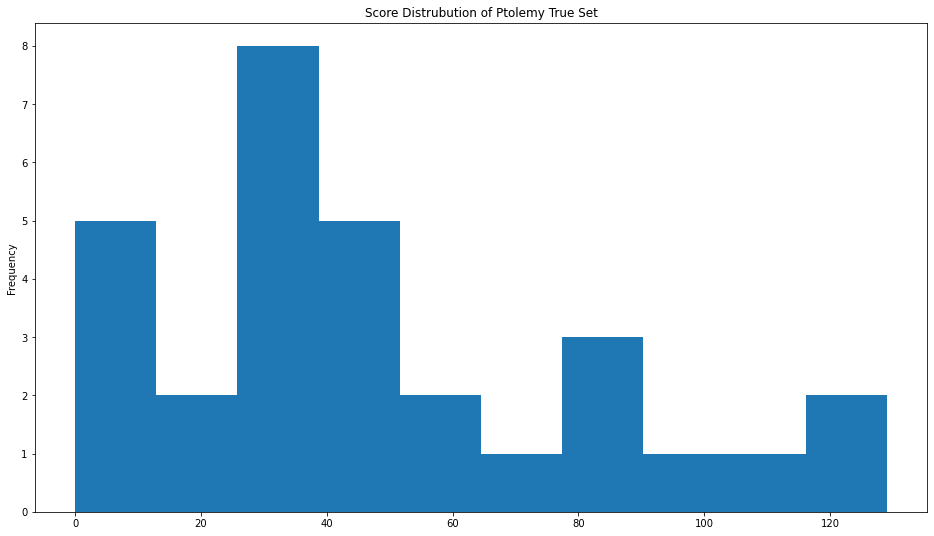

In [139]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Ptolemy True Set')
ptolemy_true['score'].plot(kind = 'hist', bins = 10);

<AxesSubplot:title={'center':'Score Distrubution of Ptolemy False Set'}, ylabel='Frequency'>

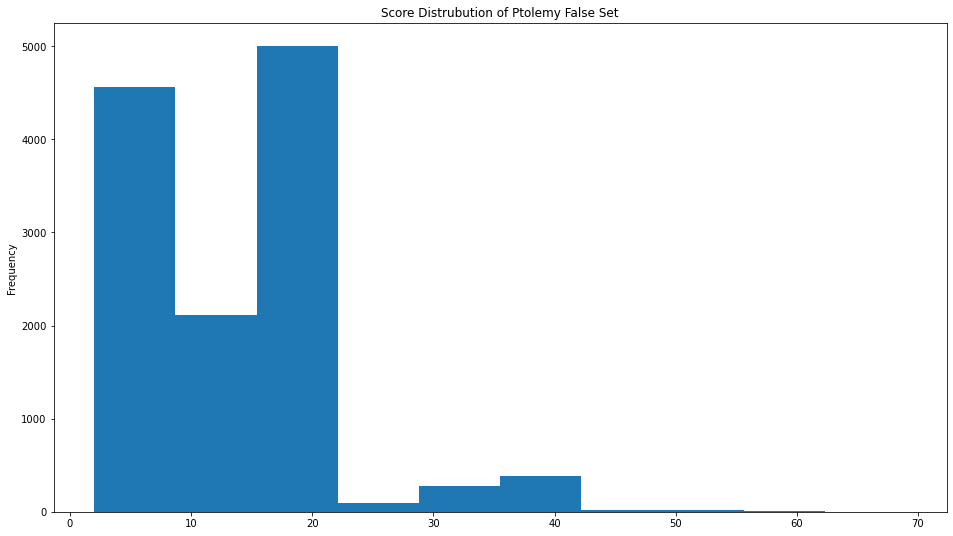

In [140]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Ptolemy False Set')
ptolemy_false.loc[ptolemy_false['score'] > 0]['score'].plot(kind = 'hist', bins = 10)

### Now we look at nissan whose score is 19 which is right around the median.

In [142]:
nissan = eval_answer_yak('nissan',1, 'seqm', .3, 1, 20)

In [143]:
nissan[0]

[('Altima', 0.00913142620717849),
 ('Sentra', 0.01361181299151163),
 ('company', 0.022610362104162406),
 ('Quest', 0.028659852070945898),
 ('model', 0.029328868247745825),
 ('frontier', 0.03770917898846666),
 ('Mercury', 0.0534153700539645),
 ('Villager', 0.0534153700539645),
 ('Datsun', 0.0534153700539645),
 ('Japanese', 0.0534153700539645),
 ('Murano', 0.0534153700539645),
 ('Sail', 0.0534153700539645),
 ('driving', 0.055110175942305946),
 ('car', 0.055110175942305946),
 ('popular', 0.08079886729312591),
 ('truckin', 0.08079886729312591),
 ('pickup', 0.08079886729312591),
 ('transportation', 0.09789627742079174),
 ('minivan', 0.09789627742079174),
 ('begin', 0.09789627742079174)]

In [144]:
nissan_true = nissan[1]
nissan_false  = nissan[2]

In [145]:
nissan_true.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
nissan_true.head(50)

category  \
39699                          on the move   
51153              begins & ends with "n\"   
82239                           top models   
71069                    driving the green   
28520                       transportation   
123089  they don't make these cars anymore   
43033                      the new car lot   
11701                              driving   
71822                            truckin\'   
78409                           auto focus   
127475                         make my car   
136698                     the company car   
78734             baby you can make my car   
90007               japan's next top model   
97091                        the apartment   
55944                           stock cars   
87661                           auto haiku   
70830                        i want my suv   
125077                        suv shopping   

                                                                                                                   question  \
39699                                                              Altima & Sentra are 2 popular models from this automaker   
51153               This automaker has asked you to "Enjoy the Ride" in its models that include the Sentra, Altima & Maxima   
82239                                                                                                Sentra, Altima, Maxima   
71069                           The Altra EV from this company that also makes the Altima can hit 75 MPH; what a (non) gas!   
28520                                                              It's the auto company that makes the Maxima & the Altima   
123089                                                                    After 2013 its Altima Coupe got the coup de grace   
43033                                               This company's '99 Quest minivan & Mercury's '99 Villager -- same thing   
11701                           A J.D. Power survey said this company's Maxima was the most trouble-free car of 1989 models   
71822                                                                           Take this company's Titan to a new frontier   
78409                       Datsun, which became this company, was changed from Datson because son meant "loss" in Japanese   
127475                                                                                         The Sentra of your attention   
136698                                                                                    Sail on by in this brand's Armada   
78734                                                 A "Quest" for a new car from this brand can lead to a new "Frontier\"   
90007                                                                                                            The Murano   
97091   The super's cousin parked his Xterra from this company in my space again--at least it's smaller than his old Armada   
55944                                                                                                                 NSANY   
87661                                                                    Its Titan pickup / 37-gallon tank / 4-hour fill-up   
70830                                                                                                                Xterra   
125077                                                                                                           Pathfinder   

        score  
39699     229  
51153     227  
82239     217  
71069     171  
28520     163  
123089    127  
43033     126  
11701      96  
71822      83  
78409      81  
127475     73  
136698     62  
78734      61  
90007      52  
97091      44  
55944      18  
87661      12  
70830       0  
125077      0

In [146]:
nissan_false.sort_values(by = 'score', axis=0, ascending=False, inplace=True)
nissan_false.head(50)

category  \
113019                 subcompacts   
67616                         cars   
115242                    business   
10517                         cars   
135743                 motorcycles   
78732     baby you can make my car   
83754    forbes' cars for the rich   
115882           driving in europe   
96501                 company cars   
106106                    handguns   
128728            i like big bucks   
118882          incredible machine   
73471                also a planet   
100968                  \"co" co.s   
71697                       design   
100067                  news to me   
80491               mythic company   
80975      an urban legend says...   
88712            wheels of fortune   
76580                 madison ave.   
130476                & a new car!   
74314        symptoms of affluenza   
129574    germany's next top model   
80703              all my children   
104487        you've gone bankrupt   
15447               transportation   
140676                   farewells   
45827                    truckin\'   
71818                    truckin\'   
5657                transportation   
98097   baby, you can drive my car   
26216          business & industry   
96503                 company cars   
96502                 company cars   
2134                          cars   
96500                 company cars   
110326      in the corporate arena   
96499                 company cars   
69324           you auto know this   
30192                company towns   
94301             that's criminal!   
127836                learn to fly   
84373                  muscle cars   
55175                 ad campaigns   
67233       when i was your age...   
84372                  muscle cars   
7341                   automobiles   
86458              is this heaven?   
5643                   advertising   
90713           board of directors   

                                                                                                                       question  \
113019                                             This company's Model 2 has been called a poster child for greenformance cars   
67616                                                                     Models from this car company include Escort & Mustang   
115242            Ferdinand Porsche designed the first model for this German company whose cars often move slower than Porsches   
10517                      Planning to market the Lexus, this Japanese company was taken to court by a co. using the name Lexis   
135743            Also known for its cars, in 2017 this Japanese company produced its 100 millionth Super Cub series motorcycle   
78732                               Use "Fusion" to gain "Focus" & discover "Five Hundred" reasons to drive this company's cars   
83754                              Put it together: IKEA founder Ingvar Kamprad drives a 240 GL from this European auto company   
115882                           In 1959 the cars of this Swedish company were the first to make a 3-point safety belt standard   
96501                                                                         Bust out a Venza diagram & drive its Camry Solara   
106106                          Weighing about 5 lbs., 1847's "Walker" model was the heaviest handgun ever made by this company   
128728                   In 2016 this car company said orders for its new Model 3 electric sedan topped $10 billion in 36 hours   
118882               The Model S from this car company named for an inventor has 0 emissions & goes from 0 to 60 in 4.2 seconds   
73471                                             Founded in 1938, it was a Ford Motor Company brand name of semi-luxury models   
100968                                    Some of the earliest revolvers by this company were the pocket, belt & holster models   
71697                                                            In 1972 this company introduced the SX-70, its first SLR 

### Similar to the prior example the highest scores of the 'false' set are lower than those of the 'true'.

In [150]:
nissan_true['score'].mean()

96.94736842105263

In [151]:
nissan_false.loc[nissan_false['score'] > 0]['score'].mean()

24.973630831643003

### The average 'true' score is much higher and the 'true' distribution is now much more even across scores. The 'false' is still skewed towards lower scores.

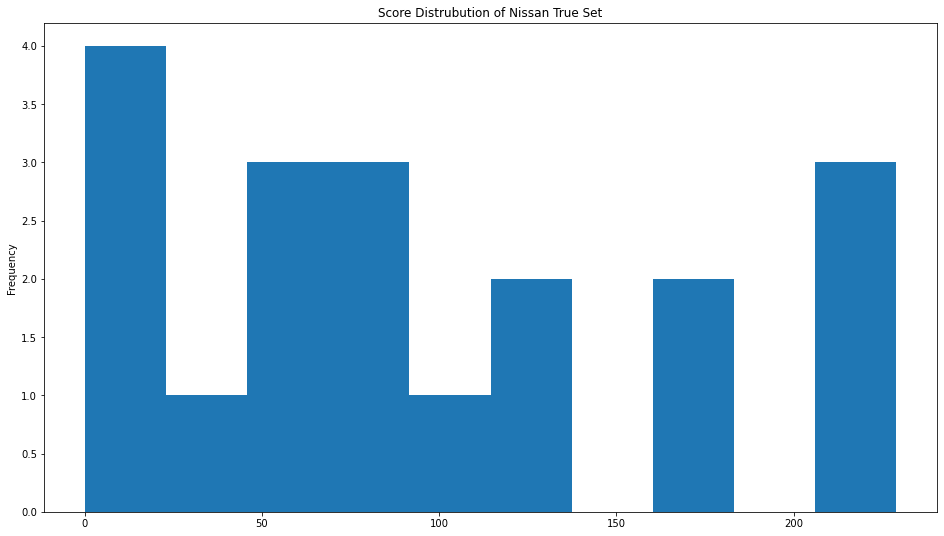

In [153]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Nissan True Set')
nissan_true['score'].plot(kind = 'hist', bins = 10);

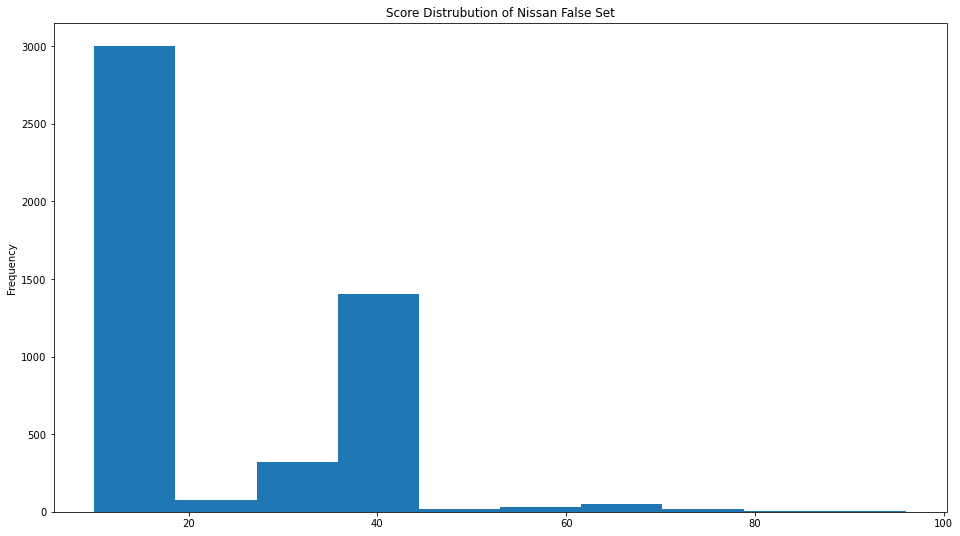

In [154]:
plt.figure(figsize = (16,9))
plt.title('Score Distrubution of Nissan False Set')
nissan_false.loc[nissan_false['score'] > 0]['score'].plot(kind = 'hist', bins = 10);

## Statistical Tests

### We will now run a hypothesis test to determine whether or not the keywords from our YAKE extraction model for a particular answer are significantly different as opposed to any other of the top answers.  We will use a 2 sample ttest to test whether the mean scores of the keywords are the same as the mean scores of any other answer where at least one keywords exists.

In [155]:
from scipy.stats import ttest_ind

In [156]:
### sample ttest for 'nissan'
test = ttest_ind(nissan_true['score'],nissan_false.loc[nissan_false['score'] > 0]['score'], random_state=42)
test

Ttest_indResult(statistic=19.6671137728229, pvalue=5.671711381475292e-83)

#### Helper functions for Ttest analysis

In [158]:
def ttest_yak(answer,n = None, df = None, dl = None, ws = None, t = None):
    '''
    This function extracts keyword from a particular answer from the get_keywords_yake function.
    A total score is computed for each question the answer appears in.
    A total score is also computed for all other questions not associated with the answer 
    where there is at least 1 keyword present.
    Then a 2 sample ttest is performed to test whether the mean of the scores between the 2 sets are significantly different.
    The keywords are stemmed before scoring for a more rigorous comparison.
    
    returns: the answer inputted, the num of words returned by the YAKE model, and the ttest results.
    '''
    
    keywords_total = get_keywords_yake(answer_dict[answer], n, df, dl, ws, t)
    keywords = keywords_total[0]
    num_words = keywords_total[1]
    keywords_dict = {get_stem(y[0]):y[1] for x,y in enumerate(keywords)}
    true_answers = pd.DataFrame(jp_top.loc[jp_top['answer'] == answer][['category','question']])
    false_answers = pd.DataFrame(jp_top.loc[jp_top['answer'] != answer][['category','question','answer']])
    true_answers['score'] = 0
    false_answers['score'] = 0
    for i in true_answers.index:
        score = 0
        st = set(prepare_stemmed_text(true_answers['category'][i] + ' ' + true_answers['question'][i]))
        for word in st:
            if word in keywords_dict.keys():
                score += 1/keywords_dict[word]
        true_answers['score'][i] = score
    
    for i in false_answers.index:
        score = 0
        st = set(prepare_stemmed_text(false_answers['category'][i] + ' ' + false_answers['question'][i]))
        for word in st:
            if word in keywords_dict.keys():
                score += 1/keywords_dict[word]
        false_answers['score'][i] = score  
    
    return (answer,num_words, ttest_ind(true_answers['score'],false_answers.loc[false_answers['score'] > 0]['score'],random_state = 42))

In [159]:
def save_p_values_to_file(filename):

    ### create empty dataframe
    p_values = pd.DataFrame()
    ### get answers
    ls = [el[0] for el in stat_results.values]
    ###get p-values
    ls2 = [el[2][1] for el in stat_results.values]
    ### get - num of words
    ls3 = [el[1] for el in stat_results.values]
    ### create [-value dataframe
    p_values = zip(ls,ls2,ls3)
    p_values_df = pd.DataFrame(p_values)
    p_values_df.rename(columns = {0:'answer', 1:'p_value',2:'num_words'}, inplace = True)
    ### save result to file
    p_values_df.to_csv('../data/' + filename + '.csv', index = False)

### The code below can take an hour or two to run so now I leave it commented.  This is what I used to get results for different thresholds and they were all saved to files.

In [ ]:
### ttest for same sample with 20 keywords and threshold 0.3

## import time
## t0 = time.time()
## ttest_results = []
## i = 1
## for answer in p_values_df['answer']:
   ## ttest_results.append(ttest_yak(answer,1, 'seqm', .3, 1, 30))
   ## print(f'Processed {i} at {round(time.time() - t0)} seconds.')
   ## i+=1

## stat_results = pd.DataFrame(ttest_results)
## stat_results.to_csv('../data/ttest__results_0.3_20.csv', index = False)
## stat_results.head()
## save_p_values_to_file('p_values_0.3_20')

### We read in a dataframe of answers and p-values of a random sample of 100 previously taken

### The average p-value is well below .05 but we found 1 with a value of .263

In [160]:
p_values_df =  pd.read_csv('../data/p_values_0.3_20.csv')

In [161]:
p_values_df.describe()

p_value  num_words
count  1.000000e+02      100.0
mean   2.628802e-03       20.0
std    2.628795e-02        0.0
min    0.000000e+00       20.0
25%    1.556161e-96       20.0
50%    5.626551e-48       20.0
75%    6.392362e-28       20.0
max    2.628795e-01       20.0

In [163]:
p_values_df.sort_values(by = 'p_value').tail(1)

answer  p_value  num_words
49  teeth  0.26288         20

### We found the outlier was 'teeth'.  Examining the keywords we can get a sense of why this list of keywords could easily be associated with an alternate answer.

In [164]:
teeth = get_keywords_yake(answer_dict['teeth'],1, 'seqm', .3, 1, 20);

In [165]:
teeth[0]

[('body', 0.008815994956867796),
 ('part', 0.011856088996367644),
 ('deciduous', 0.021042388743433383),
 ('whale', 0.021541690267919758),
 ('animal', 0.023213548509236334),
 ('Malocclusion', 0.024048399288892703),
 ('anatomy', 0.029416695098457898),
 ('horse', 0.03371533831016396),
 ('upper', 0.03461020699697011),
 ('pulp', 0.03461020699697011),
 ('bird', 0.0366794909474859),
 ('dentin', 0.041602448368000464),
 ('lack', 0.042593590683687114),
 ('zoology', 0.042593590683687114),
 ('grow', 0.042593590683687114),
 ('hippo', 0.05394901184217022),
 ('vampire', 0.05394901184217022),
 ('heterodont', 0.05394901184217022),
 ('pig', 0.05394901184217022),
 ('found', 0.05394901184217022)]

###  Based on a random sample, at these parameters we can reject the null hypothesis for 99% of the cases and say that the list of yake extraction keywords for a particular answer is significantly different as compared to any other of the top answers. 

### Testing yake using other thresholds:
### For the yake model, I tried increasing the max number of words returned from 20 to 30 to 40.
### Addtionally, I tried these at the de-dup thresholds of .3 and also .5.  Note this value can range from 0 to 1.
### I am only using a max n-gram of 1 as that more easily translates to word clouds which will be our final output.

### Below is a simple chart of the average of the p-value results below .05, the percentage of those below .05 returned, and the actual number of words returned.
### We can see the best(lowest) result occured at de-dup .5 and max words 40.  That will be our final model.
### Note that just increasing the max words did not necessarily improve the results as threshold .5 at 20 words was better than 30 words at .5. The converse is also true as 20 max words at .3 was better than 20 max words at .5.

                                             ## p-values and success rate by de-dup and max_words.
|    	| avp-value | below .05 | returned |
|----	|---------	|---------	|          |
|.3-20 	| 6.2e-9  	|    99  	|  20      |
|.3-30 	| 1.1e-10 	|   100 	|  29      |
|.3-40 	| 7.3e-12 	|   100 	|  34      |
|.5-20 	| 1.1e-8 	|    99 	|  20      |
|.5-30 	| 2.2e-6 	|   100 	|  30      |
|.5-40 	| 4.3e-12 	|   100 	|  40      |

### Now lets look at the previous outlier 'teeth' at .5 and 40

In [175]:
teeth = get_keywords_yake(answer_dict['teeth'], 1, 'seqm', .5, 1, 40)

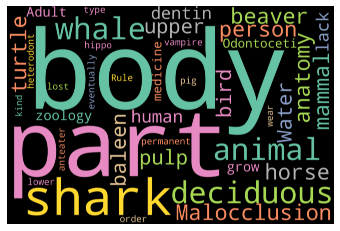

In [176]:
st = ' '.join([el[0] for el in teeth[0]])
wordcloud = WordCloud(width = 6000,prefer_horizontal=0.7, height = 4000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(st)
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusions and Recommendations

The final step for this project will be to run our final model on our 5168 common answers and build a word cloud dashboard.

We will also explain in more detail how the yake model works.

Right now we can confidently say that with the model we chose, given a set of keywords we extracted for an answer, that particular set of keywords will be unique to our answer. That is, the same set will not be extracted from any other answer. 